# Changing the order of staggering process

Let's begin with the summary of our previous ML test:
- **fc** and **Rc[3]** are the best-constrained (Error: < 0.3% within +/-1% for $10^5$ samples)
- **cc[]** parameters and **Tc[]** parameters are somewhat constrained (Error: 0.3-0.4% within +/-1% for $10^5$ samples)
- Other parameters are poorly constrained.

## A. New ordered least-square fitting
Therefore, let's go back to the least-square fitting, but with the following order.
- In the first run, let's fix all other parameters and fit only **fc**, **Rc[3]**(, **cc[]** and **Tc[]**).
- If not fit at the first level, fit **cc[]** and **Tc[]**.
- Then, by fixing the above parameters, fit **Rc[1-2]** and **kc[0]**.
- Finally, by fixing the above parameters, fit **kc[1-4]**.

### 1. Plate fiducial only. Fit **fc, Rc[3], cc[], Tc[]** at once. No iterate.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import interpolate as itpl

In [2]:
def ReadPlatePos(prefix):
    rawData = np.genfromtxt("../08_mod01_07_dataWithROCCorrection/%s.dat" % (prefix))
    arrPlt,arrPix = rawData[:,2:5],rawData[:,5:7]
    return arrPlt

In [3]:
class Parameter:
    def __init__(self):
        self.ROC = 3265.
        self.DFOV = 1200.
        self.fc = 7246.376812
        self.Tc = np.array([0,-299.408892,-3261.955597])
        self.Rc = np.array([0,0,0])	# Rotation in units of rad...
        self.kc = np.array([-0.2,0,0,0,0])		# radial distortion coefficients
        self.cc = np.array([1224,1025])
        
        
def GetFiducialParameter(prefix):
    params = Parameter()  # See Parameter::__init__ for the definition of other parameters
    params.Rc = np.array([0,0,0])	# Rotation in units of rad... see below
    
    if prefix == "MANIFEST_sim_001_coord_data_camera-1":
        params.Rc = np.array([0.097242,-0.097242,1.568608])
    elif prefix == "MANIFEST_sim_001_coord_data_camera-2":
        params.Rc = np.array([0.120983,0.032417,-0.522923])
    elif prefix == "MANIFEST_sim_001_coord_data_camera-3":
        params.Rc = np.array([0.043415,0.162026,-2.613643])
        
    return params

In [21]:
def ChangeFiducialParameter(params,valType,valPercent):
    if valPercent < -1 or valPercent > 1:
        print("Error: value error should be between -1% ~ +1%!!!")
        return params
    frac = 1.+valPercent*0.01
    
    newParams = Parameter()
    newParams.fc = params.fc
    newParams.Tc = np.copy(params.Tc)
    newParams.Rc = np.copy(params.Rc)
    newParams.kc = np.copy(params.kc)
    newParams.cc = np.copy(params.cc)
    
    if valType == "fc":
        newParams.fc *= frac
    elif valType[:2] == "Tc":
        TcTotSq = newParams.Tc[0]**2 + newParams.Tc[1]**2 + newParams.Tc[2]**2
        if valType[2] == '0':
            newParams.Tc[0] = 0.01*valPercent*newParams.Tc[1]
        else:
            newParams.Tc[1] *= frac
        newParams.Tc[2] = -np.sqrt(TcTotSq - newParams.Tc[0]**2 - newParams.Tc[1]**2)
    elif valType[:2] == "Rc":
        newParams.Rc[np.int(valType[2])] *= frac
    elif valType[:2] == "kc":
        if valType[2] == '0':
            newParams.kc[0] *= frac
        else:
            newParams.kc[np.int(valType[2])] = 1E-6*valPercent
    elif valType[:2] == "cc":
        newParams.cc[np.int(valType[2])] *= frac
    else:
        print("Error: type should be either (fc, Tc#, Rc#, kc#, cc#)")
    return newParams

In [5]:
def ConvertPlateToPix(arrPlate,params):
    
    cameraMatrix = np.array([[params.fc,0,params.cc[0]],[0,params.fc,params.cc[1]],[0,0,1]],dtype=np.float64)
    #print("Before cv2.projectPoints: Rc = ",params.Rc,params.Rc.dtype,flush=True)
    arrPix,jac = cv2.projectPoints(np.copy(arrPlate),np.array(params.Rc,dtype=np.float64),np.array(params.Tc,dtype=np.float64),cameraMatrix,params.kc)
    arrPix = arrPix.reshape(-1,2)
    
    return arrPix

"""
Returns two maps : (Xpix,Ypix) ---> (Xplt) and (Xpix,Ypix) ---> (Yplt)
from given plate alignment/camera distortion parameters and spline interpolation setup.

Input:
- params : Parameter() object that contains plate alignment/camera distortion parameters.
- kind : kind of spline interpolation ('linear','cubic','quintic')
- Ngrid : number of grids from -DFOV/2 to +DFOV/2

Output:
- mapXYpixToXplt : mapping function of (Xpix,Ypix) ---> (Xplt)
- mapXYpixToYplt : mapping function of (Xpix,Ypix) ---> (Yplt)
"""
def MakeMapPixToPlate(params,kind,Ngrid):
    
    """Step 1. Make the grid for X_plate and Y_plate"""
    Xplt,Yplt = np.mgrid[-params.DFOV*0.5:params.DFOV*0.5:Ngrid*1j,-params.DFOV*0.5:params.DFOV*0.5:Ngrid*1j]
    Xplt,Yplt = Xplt.flatten(),Yplt.flatten()
    #print("Dimension of Xplt : ",Xplt.shape)

    """Step 2. Calculate the Z_plate for each X_plate and Y_plate, and stack it"""
    Zplt = np.sqrt(params.ROC**2-Xplt**2-Yplt**2) - params.ROC
    XYZplt = np.vstack([Xplt,Yplt,Zplt]).T
    #print("Dimension of XYZplt : ",XYZplt.shape)

    """Step 3. Project 3D points to an image plane, by using OpenCV"""
    cameraMatrix = np.array([[params.fc,0,params.cc[0]],[0,params.fc,params.cc[1]],[0,0,1]])
    XYpix,Jacob = cv2.projectPoints(XYZplt,params.Rc,params.Tc,cameraMatrix,params.kc)
    XYpix = XYpix.reshape(-1,2)
    #print("Dimension of XYpix : ",XYpix.shape)

    """Step 4. Construct maps to find (Xpix,Ypix) ---> (Xplt) and (Xpix,Ypix) ---> (Yplt)"""
    mapXYpixToXplt = itpl.interp2d(XYpix[:,0],XYpix[:,1],Xplt,kind=kind)
    mapXYpixToYplt = itpl.interp2d(XYpix[:,0],XYpix[:,1],Yplt,kind=kind)

    return mapXYpixToXplt,mapXYpixToYplt

    
    
"""
Returns X/Y/Z plate position from a given X/Y camera position and mappin functions.

Input:
- arrPixPos : X/Y camera position in units of px.
- mapXYpixToXplt : mapping function of (Xpix,Ypix) ---> (Xplt)
- mapXYpixToYplt : mapping function of (Xpix,Ypix) ---> (Yplt)
- params : Parameter() object that contains plate alignment/camera distortion parameters.

Output:
	- XYZplt : X/Y/Z plate position in units of mm.
"""
def ConvertPixToPlate(arrPix,mapXYpixToXplt,mapXYpixToYplt,params):

    """Step 1. Get the Xplt and Yplt"""
    Xplt = np.array([mapXYpixToXplt(x,y) for x,y in arrPix]).flatten()
    Yplt = np.array([mapXYpixToYplt(x,y) for x,y in arrPix]).flatten()
    #print("Dimension of Xplt : ",Xplt.shape)

    """Step 2. Get the Zplt from Xplt and Yplt, and stack it"""
    Zplt = np.sqrt(params.ROC**2-Xplt**2-Yplt**2) - params.ROC
    XYZplt = np.vstack([Xplt,Yplt,Zplt]).T
    #print("Dimension of XYZplt : ",XYZplt.shape)

    return XYZplt

In [6]:
def MakePlateFiducial(N,radius,ROC):
    arrTheta = np.arange(N)*(2.*np.pi/N)
    arrX,arrY = radius*np.cos(arrTheta),radius*np.sin(arrTheta)
    arrZ = np.sqrt(ROC**2-arrX**2-arrY**2) - ROC
    
    return np.vstack([arrX,arrY,arrZ]).T

In [31]:
from scipy import optimize as opt

def RecalibrateParameter(arrPlate,arrPix,paramsFid):
    # 1. Initialize three types of parameters by using fiducial choice:
    # - criticalParam = [Tc[0],Tc[1],Rc[2],fc,cc[0],cc[1]]
    # - probableParam = [Rc[0],Rc[1],kc[0]]
    # - redundantParam = [kc[1],kc[2],kc[3],kc[4]]
    criticalParam = np.array([paramsFid.Tc[0],paramsFid.Tc[1],paramsFid.Rc[2],paramsFid.fc,paramsFid.cc[0],paramsFid.cc[1]],dtype=np.float64)
    probableParam = np.array([paramsFid.Rc[0],paramsFid.Rc[1],paramsFid.kc[0]],dtype=np.float64)
    redundantParam = np.copy(paramsFid.kc[1:])
    
    criticalFid,probableFid,redundantFid = np.copy(criticalParam),np.copy(probableParam),np.copy(redundantParam)
    
    criticalLowPercent,criticalHighPercent = criticalFid*0.99,criticalFid*1.01
    probableLowPercent,probableHighPercent = probableFid*0.99,probableFid*1.01
    
    criticalLowBound = np.minimum(criticalLowPercent,criticalHighPercent) + np.array([-np.abs(paramsFid.Tc[1]*0.01),0.,0.,0.,0.,0.],dtype=np.float64)
    criticalUpBound = np.maximum(criticalLowPercent,criticalHighPercent) + np.array([np.abs(paramsFid.Tc[1]*0.01),0.,0.,0.,0.,0.],dtype=np.float64)
    print("Range of criticalParam: ",criticalLowBound,criticalUpBound,flush=True)
    probableLowBound = np.minimum(probableLowPercent,probableHighPercent)
    probableUpBound = np.maximum(probableLowPercent,probableHighPercent)
    redundantLowBound = -1E-6 * np.ones(4)
    redundantUpBound = 1E-6 * np.ones(4)
    
    # 2. Calibrate criticalParam --> probableParam --> redundantParam
    # Here, calibrate at once.
    criticalParam = opt.least_squares(ResidueChangeCritical,criticalFid,
                                     args=(arrPlate,arrPix,probableFid,redundantFid),
                                     bounds=(criticalLowBound,criticalUpBound),
                                     ftol=1E-16,xtol=1E-16).x
    print("Result of criticalParam: ",criticalParam,flush=True)
    probableParam = opt.least_squares(ResidueChangeProbable,probableFid,
                                    args=(arrPlate,arrPix,criticalParam,redundantFid),
                                    bounds=(probableLowBound,probableUpBound),
                                    ftol=1E-16,xtol=1E-16).x
    redundantParam = opt.least_squares(ResidueChangeRedundant,redundantFid,
                                     args=(arrPlate,arrPix,criticalParam,probableParam),
                                     bounds=(redundantLowBound,redundantUpBound),
                                     ftol=1E-16,xtol=1E-16).x

    newParam = ConstructParameter(criticalParam,probableParam,redundantParam)
    print("Result of newParam: ",newParam.Tc,newParam.Rc,newParam.fc,newParam.kc,newParam.cc,flush=True)
    #return ConstructParameter(criticalParam,probableParam,redundantParam)
    return newParam


def ConstructParameter(criticalParam,probableParam,redundantParam):
    params = Parameter()
    TcSq = params.Tc[0]**2 + params.Tc[1]**2 + params.Tc[2]**2
    params.Tc = np.array([criticalParam[0],criticalParam[1],-np.sqrt(TcSq - criticalParam[0]**2 - criticalParam[1]**2)])
    params.Rc = np.array([probableParam[0],probableParam[1],criticalParam[2]])
    params.fc = criticalParam[3]
    params.kc = np.array([probableParam[2],redundantParam[0],redundantParam[1],redundantParam[2],redundantParam[3]])
    params.cc = np.array([criticalParam[4],criticalParam[5]])
    return params

def ResidueChangeCritical(criticalParam,arrPlate,arrPix,probableParam,redundantParam):
    params = ConstructParameter(criticalParam,probableParam,redundantParam)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

def ResidueChangeProbable(probableParam,arrPlate,arrPix,criticalParam,redundantParam):
    params = ConstructParameter(criticalParam,probableParam,redundantParam)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

def ResidueChangeRedundant(redundantParam,arrPlate,arrPix,criticalParam,probableParam):
    params = ConstructParameter(criticalParam,probableParam,redundantParam)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

In [7]:
def CollectPixWithinFrame(arrOld,width,height):
    indx = (arrOld[:,0] >= 0) & (arrOld[:,0] < width) & (arrOld[:,1] >= 0) & (arrOld[:,1] < height)
    return arrOld[indx,:]

def GetFiducialSubset(arrPlate,arrPixFid,arrPixNew):
    arrPlateSub = []
    for pixNew in arrPixNew:
        diffSq = (arrPixFid[:,0]-pixNew[0])**2 + (arrPixFid[:,1]-pixNew[1])**2
        indx = np.argmin(diffSq)
        arrPlateSub.append(arrPlate[indx,:])
        
    return np.array(arrPlateSub)

In [8]:
def ChangeFullFiducialParameter(paramOrig,arrPercent):
    params = ChangeFiducialParameter(paramOrig,"Tc0",arrPercent[0])
    params = ChangeFiducialParameter(params,"Tc1",arrPercent[1])
    params = ChangeFiducialParameter(params,"Rc0",arrPercent[2])
    params = ChangeFiducialParameter(params,"Rc1",arrPercent[3])
    params = ChangeFiducialParameter(params,"Rc2",arrPercent[4])
    params = ChangeFiducialParameter(params,"fc",arrPercent[5])
    params = ChangeFiducialParameter(params,"kc0",arrPercent[6])
    params = ChangeFiducialParameter(params,"kc1",arrPercent[7])
    params = ChangeFiducialParameter(params,"kc2",arrPercent[8])
    params = ChangeFiducialParameter(params,"kc3",arrPercent[9])
    params = ChangeFiducialParameter(params,"kc4",arrPercent[10])
    params = ChangeFiducialParameter(params,"cc0",arrPercent[11])
    params = ChangeFiducialParameter(params,"cc1",arrPercent[12])
    
    return params

Range of criticalParam:  [ -2.99408892e+00  -3.02402981e+02   1.55292192e+00   7.17391304e+03
   1.21176000e+03   1.01475000e+03] [  2.99408892e+00  -2.96414803e+02   1.58429408e+00   7.31884058e+03
   1.23624000e+03   1.03525000e+03]


C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


Result of criticalParam:  [ -1.14008171e+00  -3.00527272e+02   1.57734388e+00   7.30712083e+03
   1.22802178e+03   1.02378471e+03]
Result of newParam:  [ -1.14008171e+00  -3.00527272e+02  -3.26185255e+03] [ 0.09746673 -0.09728494  1.57734388] 7307.12083343 [ -1.98000000e-01   1.00000000e-06   1.00000000e-06  -9.99837869e-07
   1.00000000e-06] [ 1228.02177971  1023.78471357]
Fiducial Tc[1]: -299.408892, estimated Tc[1]: -300.527272, error: 0.373529 %
Fiducial Rc[3]: 1.568608, estimated Rc[3]: 1.577344, error: 0.556919 %
Fiducial fc: 7246.376812, estimated fc: 7307.120833, error: 0.838267 %
Range of criticalParam:  [ -2.99408892e+00  -3.02402981e+02   1.55292192e+00   7.17391304e+03
   1.21176000e+03   1.01475000e+03] [  2.99408892e+00  -2.96414803e+02   1.58429408e+00   7.31884058e+03
   1.23624000e+03   1.03525000e+03]
Result of criticalParam:  [ -1.27139796e+00  -2.99286758e+02   1.58353207e+00   7.22147042e+03
   1.22971010e+03   1.02416590e+03]
Result of newParam:  [ -1.27139796e+00

<Figure size 432x288 with 0 Axes>

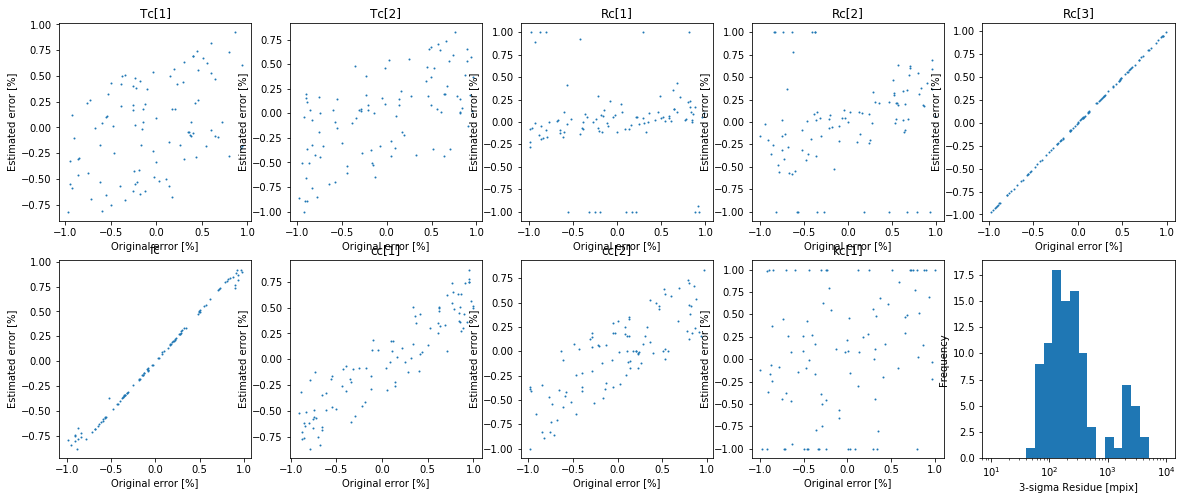

In [33]:
%matplotlib inline

# Get the fiducial choice for camera 1
prefix = "MANIFEST_sim_001_coord_data_camera-1"
params = GetFiducialParameter(prefix)
plateTarget = ReadPlatePos(prefix)
plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)

pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

WIDTH,HEIGHT = 2448,2050

plt.clf()
fig,axs = plt.subplots(2,5,figsize=(20,8))
axs = axs.flatten()

# Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
Nvar = 100
randVar = np.random.rand(Nvar,13)*2-1.

arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

errBudget = []
for rv,ivar in zip(randVar,range(1,Nvar+1)):
    newParams = ChangeFullFiducialParameter(params,rv)
    pixTarget = ConvertPlateToPix(plateTarget,newParams)
    pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
        
    pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
    plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
    
    estParams = RecalibrateParameter(plateFiducialSub,pixFiducialSub,params)
    arrTcAE.append(estParams.Tc[0]/params.Tc[1]*100)
    arrTcBE.append((estParams.Tc[1]-params.Tc[1])/params.Tc[1]*100)
    print("Fiducial Tc[1]: %f, estimated Tc[1]: %f, error: %f %%" % (params.Tc[1],estParams.Tc[1],arrTcBE[-1]),flush=True)
    arrRcAE.append((estParams.Rc[0]-params.Rc[0])/params.Rc[0]*100)
    arrRcBE.append((estParams.Rc[1]-params.Rc[1])/params.Rc[1]*100)
    arrRcCE.append((estParams.Rc[2]-params.Rc[2])/params.Rc[2]*100)
    print("Fiducial Rc[3]: %f, estimated Rc[3]: %f, error: %f %%" % (params.Rc[2],estParams.Rc[2],arrRcCE[-1]),flush=True)
    arrFcE.append((estParams.fc-params.fc)/params.fc*100)
    print("Fiducial fc: %f, estimated fc: %f, error: %f %%" % (params.fc,estParams.fc,arrFcE[-1]),flush=True)
    arrCcAE.append((estParams.cc[0]-params.cc[0])/params.cc[0]*100)
    arrCcBE.append((estParams.cc[1]-params.cc[1])/params.cc[1]*100)
    arrKcAE.append((estParams.kc[0]-params.kc[0])/params.kc[0]*100)

    estPixTarget = ConvertPlateToPix(plateTarget,estParams)
    residues = np.sqrt((estPixTarget[:,0]-pixTarget[:,0])**2 + (estPixTarget[:,1]-pixTarget[:,1])**2)*1E3
    
    errBudget.append(np.percentile(residues,99.865))
    
print("Error in Rc[3]: ",arrRcCE,flush=True)


for ax,orig,est,valType in zip(axs[:-1],
                                [arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO],
                              [arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE],
                              ["Tc[1]","Tc[2]","Rc[1]","Rc[2]","Rc[3]","fc","cc[1]","cc[2]","kc[1]"]):
    ax.scatter(orig,est,s=1,rasterized=True)
    ax.set_title(valType)
    ax.set_xlabel("Original error [%]")
    ax.set_ylabel("Estimated error [%]")
    
axs[-1].hist(errBudget,bins=np.logspace(1,4,21))
axs[-1].set_xlabel("3-sigma Residue [mpix]")
axs[-1].set_xscale("log")
axs[-1].set_ylabel("Frequency")
plt.savefig("output/3step_noIterate.pdf",bbox_inches="tight",dpi=150)

### 2. Plate fiducial only. Fit **fc, Rc[3]** first. No iterate.

In [34]:
from scipy import optimize as opt

def RecalibrateParameter(arrPlate,arrPix,paramsFid):
    # 1. Initialize three types of parameters by using fiducial choice:
    # - criticalAParam = [Rc[2],fc]
    # - criticalBParam = [Tc[0],Tc[1],cc[0],cc[1]]
    # - probableParam = [Rc[0],Rc[1],kc[0]]
    # - redundantParam = [kc[1],kc[2],kc[3],kc[4]]
    criticalAFid = np.array([paramsFid.Rc[2],paramsFid.fc],dtype=np.float64)
    criticalBFid = np.array([paramsFid.Tc[0],paramsFid.Tc[1],paramsFid.cc[0],paramsFid.cc[1]],dtype=np.float64)
    probableFid = np.array([paramsFid.Rc[0],paramsFid.Rc[1],paramsFid.kc[0]],dtype=np.float64)
    redundantFid = np.copy(paramsFid.kc[1:])
    
    criticalALP,criticalAHP = criticalAFid*0.99,criticalAFid*1.01
    criticalBLP,criticalBHP = criticalBFid*0.99,criticalBFid*1.01
    probableLP,probableHP = probableFid*0.99,probableFid*1.01
    
    criticalALB,criticalAUB = np.minimum(criticalALP,criticalAHP),np.maximum(criticalALP,criticalAHP)
    criticalBLB = np.minimum(criticalBLP,criticalBHP) + np.array([-np.abs(paramsFid.Tc[1]*0.01),0,0,0])
    criticalBUB = np.maximum(criticalBLP,criticalBHP) + np.array([np.abs(paramsFid.Tc[1]*0.01),0,0,0])
    probableLB,probableUB = np.minimum(probableLP,probableHP),np.maximum(probableLP,probableHP)
    redundantLB,redundantUB = -1E-6*np.ones(4),1E-6*np.ones(4)
    
    # 2. Calibrate criticalAParam --> criticalBParam --> probableParam --> redundantParam
    # Here, calibrate at once.
    criticalA = opt.least_squares(ResidueChangeCriticalA,criticalAFid,
                                     args=(arrPlate,arrPix,criticalBFid,probableFid,redundantFid),
                                     bounds=(criticalALB,criticalAUB),
                                     ftol=1E-16,xtol=1E-16).x
    print("Result of criticalParam: ",criticalA,flush=True)
    criticalB = opt.least_squares(ResidueChangeCriticalB,criticalBFid,
                                      args=(arrPlate,arrPix,criticalA,probableFid,redundantFid),
                                      bounds=(criticalBLB,criticalBUB),
                                      ftol=1E-16,xtol=1E-16).x
    probable = opt.least_squares(ResidueChangeProbable,probableFid,
                                    args=(arrPlate,arrPix,criticalA,criticalB,redundantFid),
                                    bounds=(probableLB,probableUB),
                                    ftol=1E-16,xtol=1E-16).x
    redundant = opt.least_squares(ResidueChangeRedundant,redundantFid,
                                     args=(arrPlate,arrPix,criticalA,criticalB,probable),
                                     bounds=(redundantLB,redundantUB),
                                     ftol=1E-16,xtol=1E-16).x

    newParam = ConstructParameter(criticalA,criticalB,probable,redundant)
    print("Result of newParam: ",newParam.Tc,newParam.Rc,newParam.fc,newParam.kc,newParam.cc,flush=True)
    return newParam


def ConstructParameter(criticalA,criticalB,probable,redundant):
    params = Parameter()
    TcSq = params.Tc[0]**2 + params.Tc[1]**2 + params.Tc[2]**2
    params.Tc = np.array([criticalB[0],criticalB[1],-np.sqrt(TcSq - criticalB[0]**2 - criticalB[1]**2)])
    params.Rc = np.array([probable[0],probable[1],criticalA[0]])
    params.fc = criticalA[1]
    params.kc = np.array([probable[2],redundant[0],redundant[1],redundant[2],redundant[3]])
    params.cc = np.array([criticalB[2],criticalB[3]])
    return params

def ResidueChangeCriticalA(criticalA,arrPlate,arrPix,criticalB,probable,redundant):
    params = ConstructParameter(criticalA,criticalB,probable,redundant)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

def ResidueChangeCriticalB(criticalB,arrPlate,arrPix,criticalA,probable,redundant):
    params = ConstructParameter(criticalA,criticalB,probable,redundant)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

def ResidueChangeProbable(probable,arrPlate,arrPix,criticalA,criticalB,redundant):
    params = ConstructParameter(criticalA,criticalB,probable,redundant)    
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

def ResidueChangeRedundant(redundant,arrPlate,arrPix,criticalA,criticalB,probable):
    params = ConstructParameter(criticalA,criticalB,probable,redundant)    
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

Result of criticalParam:  [  1.55562117e+00   7.21737502e+03]


C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


Result of newParam:  [ -7.61858139e-01  -3.02387827e+02  -3.26168071e+03] [ 0.09821442 -0.09821442  1.55562117] 7217.37502211 [ -1.98000000e-01   1.00000000e-06  -1.00000000e-06  -9.99999999e-07
   1.00000000e-06] [ 1221.25326476  1023.6560563 ]
Fiducial Tc[1]: -299.408892, estimated Tc[1]: -302.387827, error: 0.994939 %
Fiducial Rc[3]: 1.568608, estimated Rc[3]: 1.555621, error: -0.827921 %
Fiducial fc: 7246.376812, estimated fc: 7217.375022, error: -0.400225 %
Result of criticalParam:  [  1.57879833e+00   7.27833284e+03]
Result of newParam:  [  2.06593811e+00  -2.96414830e+02  -3.26222838e+03] [ 0.09626958 -0.09626958  1.57879833] 7278.33284008 [ -2.02000000e-01  -1.00000000e-06   1.00000000e-06   1.00000000e-06
  -1.00000000e-06] [ 1229.47996035  1025.03278372]
Fiducial Tc[1]: -299.408892, estimated Tc[1]: -296.414830, error: -0.999991 %
Fiducial Rc[3]: 1.568608, estimated Rc[3]: 1.578798, error: 0.649642 %
Fiducial fc: 7246.376812, estimated fc: 7278.332840, error: 0.440993 %
Resul

<Figure size 432x288 with 0 Axes>

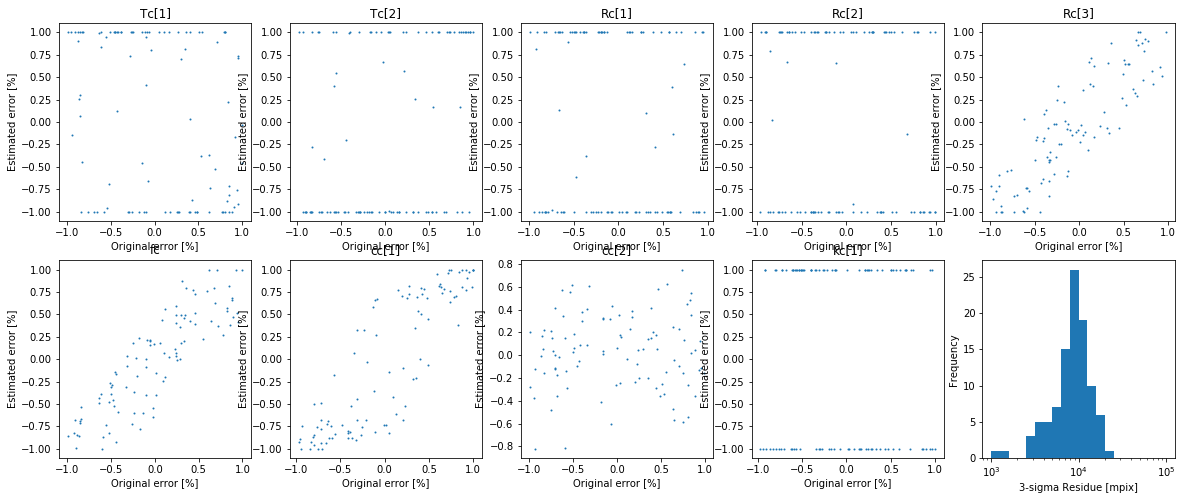

In [36]:
%matplotlib inline

# Get the fiducial choice for camera 1
prefix = "MANIFEST_sim_001_coord_data_camera-1"
params = GetFiducialParameter(prefix)
plateTarget = ReadPlatePos(prefix)
plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)

pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

WIDTH,HEIGHT = 2448,2050

plt.clf()
fig,axs = plt.subplots(2,5,figsize=(20,8))
axs = axs.flatten()

# Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
Nvar = 100
randVar = np.random.rand(Nvar,13)*2-1.

arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

errBudget = []
for rv,ivar in zip(randVar,range(1,Nvar+1)):
    newParams = ChangeFullFiducialParameter(params,rv)
    pixTarget = ConvertPlateToPix(plateTarget,newParams)
    pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
        
    pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
    plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
    
    estParams = RecalibrateParameter(plateFiducialSub,pixFiducialSub,params)
    arrTcAE.append(estParams.Tc[0]/params.Tc[1]*100)
    arrTcBE.append((estParams.Tc[1]-params.Tc[1])/params.Tc[1]*100)
    print("Fiducial Tc[1]: %f, estimated Tc[1]: %f, error: %f %%" % (params.Tc[1],estParams.Tc[1],arrTcBE[-1]),flush=True)
    arrRcAE.append((estParams.Rc[0]-params.Rc[0])/params.Rc[0]*100)
    arrRcBE.append((estParams.Rc[1]-params.Rc[1])/params.Rc[1]*100)
    arrRcCE.append((estParams.Rc[2]-params.Rc[2])/params.Rc[2]*100)
    print("Fiducial Rc[3]: %f, estimated Rc[3]: %f, error: %f %%" % (params.Rc[2],estParams.Rc[2],arrRcCE[-1]),flush=True)
    arrFcE.append((estParams.fc-params.fc)/params.fc*100)
    print("Fiducial fc: %f, estimated fc: %f, error: %f %%" % (params.fc,estParams.fc,arrFcE[-1]),flush=True)
    arrCcAE.append((estParams.cc[0]-params.cc[0])/params.cc[0]*100)
    arrCcBE.append((estParams.cc[1]-params.cc[1])/params.cc[1]*100)
    arrKcAE.append((estParams.kc[0]-params.kc[0])/params.kc[0]*100)

    estPixTarget = ConvertPlateToPix(plateTarget,estParams)
    residues = np.sqrt((estPixTarget[:,0]-pixTarget[:,0])**2 + (estPixTarget[:,1]-pixTarget[:,1])**2)*1E3
    
    errBudget.append(np.percentile(residues,99.865))
    
print("Error in Rc[3]: ",arrRcCE,flush=True)


for ax,orig,est,valType in zip(axs[:-1],
                                [arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO],
                              [arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE],
                              ["Tc[1]","Tc[2]","Rc[1]","Rc[2]","Rc[3]","fc","cc[1]","cc[2]","kc[1]"]):
    ax.scatter(orig,est,s=1,rasterized=True)
    ax.set_title(valType)
    ax.set_xlabel("Original error [%]")
    ax.set_ylabel("Estimated error [%]")
    
axs[-1].hist(errBudget,bins=np.logspace(3,5,21))
axs[-1].set_xlabel("3-sigma Residue [mpix]")
axs[-1].set_xscale("log")
axs[-1].set_ylabel("Frequency")
plt.savefig("output/4step_noIterate.pdf",bbox_inches="tight",dpi=150)

### 3. Plate fiducial only. Fit **fc, Rc[3], cc[]** first. No iterate.

In [37]:
from scipy import optimize as opt

def RecalibrateParameter(arrPlate,arrPix,paramsFid):
    # 1. Initialize three types of parameters by using fiducial choice:
    # - criticalAParam = [Rc[2],fc,cc[0],cc[1]]
    # - criticalBParam = [Tc[0],Tc[1]]
    # - probableParam = [Rc[0],Rc[1],kc[0]]
    # - redundantParam = [kc[1],kc[2],kc[3],kc[4]]
    criticalAFid = np.array([paramsFid.Rc[2],paramsFid.fc,paramsFid.cc[0],paramsFid.cc[1]],dtype=np.float64)
    criticalBFid = np.array([paramsFid.Tc[0],paramsFid.Tc[1]],dtype=np.float64)
    probableFid = np.array([paramsFid.Rc[0],paramsFid.Rc[1],paramsFid.kc[0]],dtype=np.float64)
    redundantFid = np.copy(paramsFid.kc[1:])
    
    criticalALP,criticalAHP = criticalAFid*0.99,criticalAFid*1.01
    criticalBLP,criticalBHP = criticalBFid*0.99,criticalBFid*1.01
    probableLP,probableHP = probableFid*0.99,probableFid*1.01
    
    criticalALB,criticalAUB = np.minimum(criticalALP,criticalAHP),np.maximum(criticalALP,criticalAHP)
    criticalBLB = np.minimum(criticalBLP,criticalBHP) + np.array([-np.abs(paramsFid.Tc[1]*0.01),0])
    criticalBUB = np.maximum(criticalBLP,criticalBHP) + np.array([np.abs(paramsFid.Tc[1]*0.01),0])
    probableLB,probableUB = np.minimum(probableLP,probableHP),np.maximum(probableLP,probableHP)
    redundantLB,redundantUB = -1E-6*np.ones(4),1E-6*np.ones(4)
    
    # 2. Calibrate criticalAParam --> criticalBParam --> probableParam --> redundantParam
    # Here, calibrate at once.
    criticalA = opt.least_squares(ResidueChangeCriticalA,criticalAFid,
                                     args=(arrPlate,arrPix,criticalBFid,probableFid,redundantFid),
                                     bounds=(criticalALB,criticalAUB),
                                     ftol=1E-16,xtol=1E-16).x
    print("Result of criticalParam: ",criticalA,flush=True)
    criticalB = opt.least_squares(ResidueChangeCriticalB,criticalBFid,
                                      args=(arrPlate,arrPix,criticalA,probableFid,redundantFid),
                                      bounds=(criticalBLB,criticalBUB),
                                      ftol=1E-16,xtol=1E-16).x
    probable = opt.least_squares(ResidueChangeProbable,probableFid,
                                    args=(arrPlate,arrPix,criticalA,criticalB,redundantFid),
                                    bounds=(probableLB,probableUB),
                                    ftol=1E-16,xtol=1E-16).x
    redundant = opt.least_squares(ResidueChangeRedundant,redundantFid,
                                     args=(arrPlate,arrPix,criticalA,criticalB,probable),
                                     bounds=(redundantLB,redundantUB),
                                     ftol=1E-16,xtol=1E-16).x

    newParam = ConstructParameter(criticalA,criticalB,probable,redundant)
    print("Result of newParam: ",newParam.Tc,newParam.Rc,newParam.fc,newParam.kc,newParam.cc,flush=True)
    return newParam


def ConstructParameter(criticalA,criticalB,probable,redundant):
    params = Parameter()
    TcSq = params.Tc[0]**2 + params.Tc[1]**2 + params.Tc[2]**2
    params.Tc = np.array([criticalB[0],criticalB[1],-np.sqrt(TcSq - criticalB[0]**2 - criticalB[1]**2)])
    params.Rc = np.array([probable[0],probable[1],criticalA[0]])
    params.fc = criticalA[1]
    params.kc = np.array([probable[2],redundant[0],redundant[1],redundant[2],redundant[3]])
    params.cc = np.array([criticalA[2],criticalA[3]])
    return params

def ResidueChangeCriticalA(criticalA,arrPlate,arrPix,criticalB,probable,redundant):
    params = ConstructParameter(criticalA,criticalB,probable,redundant)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

def ResidueChangeCriticalB(criticalB,arrPlate,arrPix,criticalA,probable,redundant):
    params = ConstructParameter(criticalA,criticalB,probable,redundant)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

def ResidueChangeProbable(probable,arrPlate,arrPix,criticalA,criticalB,redundant):
    params = ConstructParameter(criticalA,criticalB,probable,redundant)    
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

def ResidueChangeRedundant(redundant,arrPlate,arrPix,criticalA,criticalB,probable):
    params = ConstructParameter(criticalA,criticalB,probable,redundant)    
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


Result of criticalParam:  [  1.57770999e+00   7.19052241e+03   1.22491297e+03   1.01947601e+03]
Result of newParam:  [ -3.66635538e-04  -2.99408995e+02  -3.26195559e+03] [ 0.0972722  -0.09721304  1.57770999] 7190.52240726 [ -1.99775254e-01  -9.96839924e-07  -8.02147266e-07  -2.76218922e-07
  -9.99999990e-07] [ 1224.91296613  1019.47601169]
Fiducial Tc[1]: -299.408892, estimated Tc[1]: -299.408995, error: 0.000035 %
Fiducial Rc[3]: 1.568608, estimated Rc[3]: 1.577710, error: 0.580259 %
Fiducial fc: 7246.376812, estimated fc: 7190.522407, error: -0.770791 %
Result of criticalParam:  [  1.57260396e+00   7.21747064e+03   1.22348932e+03   1.02719501e+03]
Result of newParam:  [ -3.54569159e-05  -2.99408900e+02  -3.26195560e+03] [ 0.09723495 -0.09729857  1.57260396] 7217.47063803 [ -2.00130502e-01   9.73698455e-07   9.99997366e-07   9.82686816e-07
  -9.99925849e-07] [ 1223.48932473  1027.19500584]
Fiducial Tc[1]: -299.408892, estimated Tc[1]: -299.408900, error: 0.000003 %
Fiducial Rc[3]: 1.5

<Figure size 432x288 with 0 Axes>

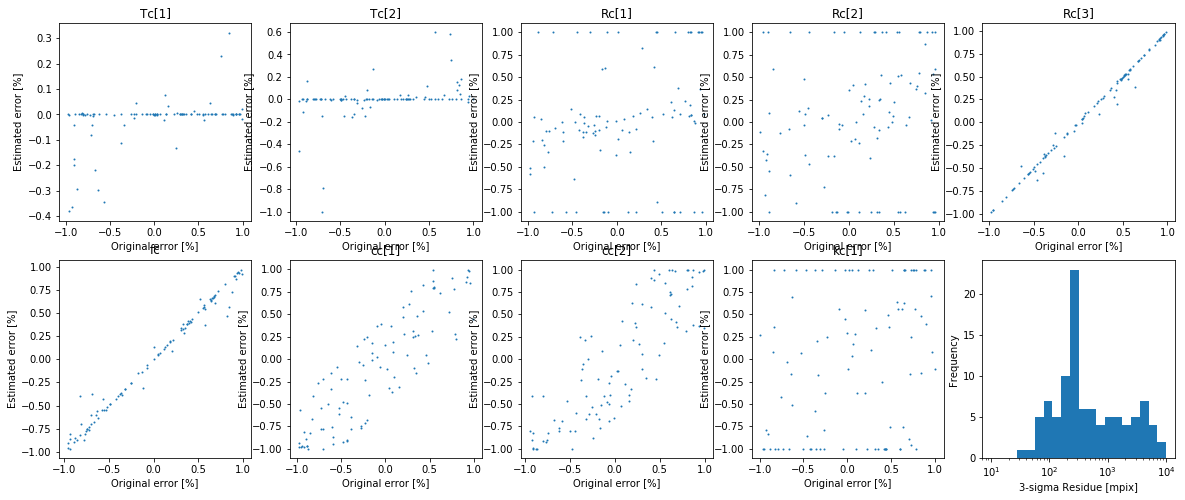

In [39]:
%matplotlib inline

# Get the fiducial choice for camera 1
prefix = "MANIFEST_sim_001_coord_data_camera-1"
params = GetFiducialParameter(prefix)
plateTarget = ReadPlatePos(prefix)
plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)

pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

WIDTH,HEIGHT = 2448,2050

plt.clf()
fig,axs = plt.subplots(2,5,figsize=(20,8))
axs = axs.flatten()

# Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
Nvar = 100
randVar = np.random.rand(Nvar,13)*2-1.

arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

errBudget = []
for rv,ivar in zip(randVar,range(1,Nvar+1)):
    newParams = ChangeFullFiducialParameter(params,rv)
    pixTarget = ConvertPlateToPix(plateTarget,newParams)
    pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
        
    pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
    plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
    
    estParams = RecalibrateParameter(plateFiducialSub,pixFiducialSub,params)
    arrTcAE.append(estParams.Tc[0]/params.Tc[1]*100)
    arrTcBE.append((estParams.Tc[1]-params.Tc[1])/params.Tc[1]*100)
    print("Fiducial Tc[1]: %f, estimated Tc[1]: %f, error: %f %%" % (params.Tc[1],estParams.Tc[1],arrTcBE[-1]),flush=True)
    arrRcAE.append((estParams.Rc[0]-params.Rc[0])/params.Rc[0]*100)
    arrRcBE.append((estParams.Rc[1]-params.Rc[1])/params.Rc[1]*100)
    arrRcCE.append((estParams.Rc[2]-params.Rc[2])/params.Rc[2]*100)
    print("Fiducial Rc[3]: %f, estimated Rc[3]: %f, error: %f %%" % (params.Rc[2],estParams.Rc[2],arrRcCE[-1]),flush=True)
    arrFcE.append((estParams.fc-params.fc)/params.fc*100)
    print("Fiducial fc: %f, estimated fc: %f, error: %f %%" % (params.fc,estParams.fc,arrFcE[-1]),flush=True)
    arrCcAE.append((estParams.cc[0]-params.cc[0])/params.cc[0]*100)
    arrCcBE.append((estParams.cc[1]-params.cc[1])/params.cc[1]*100)
    arrKcAE.append((estParams.kc[0]-params.kc[0])/params.kc[0]*100)

    estPixTarget = ConvertPlateToPix(plateTarget,estParams)
    residues = np.sqrt((estPixTarget[:,0]-pixTarget[:,0])**2 + (estPixTarget[:,1]-pixTarget[:,1])**2)*1E3
    
    errBudget.append(np.percentile(residues,99.865))
    
print("Error in Rc[3]: ",arrRcCE,flush=True)


for ax,orig,est,valType in zip(axs[:-1],
                                [arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO],
                              [arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE],
                              ["Tc[1]","Tc[2]","Rc[1]","Rc[2]","Rc[3]","fc","cc[1]","cc[2]","kc[1]"]):
    ax.scatter(orig,est,s=1,rasterized=True)
    ax.set_title(valType)
    ax.set_xlabel("Original error [%]")
    ax.set_ylabel("Estimated error [%]")
    
axs[-1].hist(errBudget,bins=np.logspace(1,4,21))
axs[-1].set_xlabel("3-sigma Residue [mpix]")
axs[-1].set_xscale("log")
axs[-1].set_ylabel("Frequency")
plt.savefig("output/4step2_noIterate.pdf",bbox_inches="tight",dpi=150)

## B. Fit some critical parameters by hand

The above tests show that least-square fitting can easily blows out even **fc** and **Rc[3]** to somewhere close to their fitting boundaries.
However, they should be estimate somewhat even in analytic ways.
(Of course, such analytic ways may not be accurate because of effects from other parameters, but since the current LSQ-fit performance is too poor, it is worthwhile to try it anyway.)

Suppose that a given fiducial model $\tilde{\mathcal{M}}$, a set of fiducial plates will have ideal camer position $\tilde{X}_{\rm c}^i$ for plate position $X_{\rm p}^i$.
However, in actual model $\mathcal{M}$, their camera position become $X_{\rm c}^i$.

Then....
- Draw a best-fit circle for $\tilde{X}_{\rm c}^i$ and $X_{\rm c}^i$, and mark them as $\tilde{\mathcal{C}}$ and $\mathcal{C}$, respectively.
- **cc[]** between $\tilde{\mathcal{M}}$ and $\mathcal{M}$ would be roughtly the difference between the centers of $\tilde{\mathcal{C}}$ and $\mathcal{C}$.
- **fc** between $\tilde{\mathcal{M}}$ and $\mathcal{M}$ would be roughtly the difference between the radii of $\tilde{\mathcal{C}}$ and $\mathcal{C}$.
- **Rc[3]** between $\tilde{\mathcal{M}}$ and $\mathcal{M}$ would be roughtly the difference between the angles of plate fiducials measured in $\tilde{\mathcal{C}}$ and $\mathcal{C}$.

Of course, we need to chech the sign of each way (add/subtract? multiply/divide?), since it is always confusing.
Let's try!

In [15]:
import scipy.optimize as opt

def GetCircle(arrPix):
    posExtrema = GetPosExtrema(arrPix)
    fidCenter = FindCircumCircle(posExtrema)
    fidRad = np.sqrt((arrPix[0,0]-fidCenter[0])**2 + (arrPix[0,1]-fidCenter[1])**2)
    fidCircle = np.array([fidCenter[0],fidCenter[1],fidRad])
    newCircle = opt.least_squares(ResidueRadius,fidCircle,
                                 args=(arrPix,),bounds=([0,0,0],[np.inf,np.inf,np.inf]),
                                 ftol=1E-16,xtol=1E-16).x
    return newCircle

def GetPosExtrema(arrPos):
    #print(np.argmax(arrPos,axis=0),np.argmin(arrPos,axis=0),flush=True)
    indxExtreme = list(set(np.argmax(arrPos,axis=0).flatten()) | set(np.argmin(arrPos,axis=0).flatten()))
    if len(indxExtreme) < 3:
        print("Warning: number of extreme points is less than 3!",flush=True)
        print("Original points: ",arrPos,flush=True)
        
    indxExtreme = indxExtreme[:3]
    #print(indxExtreme,flush=True)
    newPos = arrPos[indxExtreme,:]
        
    #print("Result of extrema positions: ",newPos,flush=True)
    return np.array(newPos)

def FindCircumCircle(arrPos):
    slopeA,posA = -(arrPos[1,0]-arrPos[0,0])/(arrPos[1,1]-arrPos[0,1]),0.5*(arrPos[0,:]+arrPos[1,:])
    slopeB,posB = -(arrPos[2,0]-arrPos[1,0])/(arrPos[2,1]-arrPos[1,1]),0.5*(arrPos[1,:]+arrPos[2,:])
    xcen = (slopeA*posA[0] - slopeB*posB[0] - posA[1] + posB[1])/(slopeA - slopeB)
    ycen = slopeA*(xcen - posA[0]) + posA[1]
    return np.array([xcen,ycen])

def ResidueRadius(circle,arrPix):
    arrR = np.sqrt((arrPix[:,0]-circle[0])**2 + (arrPix[:,1]-circle[1])**2)
    return np.sqrt(np.sum((arrR-circle[2])**2))    

### 1. Check **cc[]**

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


circle at fiducial/estimated choice:  [ 1224.00000003  1661.49810886  1313.19479953] [ 1223.89217646  1659.33802844  1325.95924529]
circle at fiducial/estimated choice:  [ 1224.00000003  1661.49810886  1313.19479953] [ 1222.84971098  1673.3877865   1319.96069327]
circle at fiducial/estimated choice:  [ 1224.00000003  1661.49810886  1313.19479953] [ 1215.29861057  1646.42497272  1298.77881493]
circle at fiducial/estimated choice:  [ 1224.00000003  1661.49810886  1313.19479953] [ 1218.36685659  1654.97731648  1305.46329501]
circle at fiducial/estimated choice:  [ 1224.00000003  1661.49810886  1313.19479953] [ 1217.65382425  1673.26912318  1322.37679581]
circle at fiducial/estimated choice:  [ 1224.00000003  1661.49810886  1313.19479953] [ 1241.50555172  1652.71255659  1314.13240682]
circle at fiducial/estimated choice:  [ 1224.00000003  1661.49810886  1313.19479953] [ 1207.49176954  1650.38638093  1312.94758274]
circle at fiducial/estimated choice:  [ 1224.00000003  1661.49810886  1313.1

<Figure size 432x288 with 0 Axes>

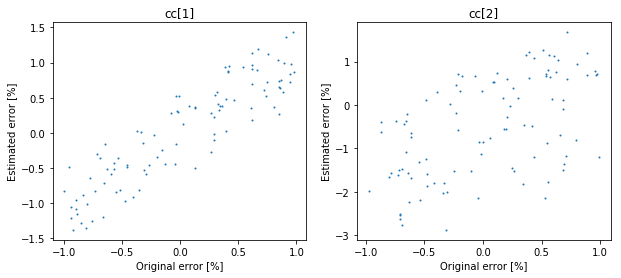

In [30]:
%matplotlib inline

# Get the fiducial choice for camera 1
prefix = "MANIFEST_sim_001_coord_data_camera-1"
params = GetFiducialParameter(prefix)
plateTarget = ReadPlatePos(prefix)
plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)

pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

WIDTH,HEIGHT = 2448,2050

pixFiducialFidSub = CollectPixWithinFrame(pixFiducialFid,WIDTH,HEIGHT)
circleFid = GetCircle(pixFiducialFidSub)
#print("pixFiducialFidSub: ",pixFiducialFidSub,flush=True)

# Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
Nvar = 100
randVar = np.random.rand(Nvar,13)*2-1.

arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

errBudget = []
for rv,ivar in zip(randVar,range(1,Nvar+1)):
    newParams = ChangeFullFiducialParameter(params,rv)
    pixTarget = ConvertPlateToPix(plateTarget,newParams)
    pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
        
    pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
    plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
    
    circleEst = GetCircle(pixFiducialSub)
    print("circle at fiducial/estimated choice: ",circleFid,circleEst,flush=True)
    
    """
    fig,axs = plt.subplots(1,2,figsize=(10,4))
    axs = axs.flatten()
    axs[0].plot(pixFiducialFidSub[:,0],pixFiducialFidSub[:,1],'r+')
    axs[0].plot(circleFid[2]*np.cos(np.linspace(0,2*np.pi,51))+circleFid[0],
            circleFid[2]*np.sin(np.linspace(0,2*np.pi,51))+circleFid[1],'b-')
    axs[1].plot(pixFiducialSub[:,0],pixFiducialSub[:,1],'r+')
    axs[1].plot(circleEst[2]*np.cos(np.linspace(0,2*np.pi,51))+circleEst[0],
            circleEst[2]*np.sin(np.linspace(0,2*np.pi,51))+circleEst[1],'b-')
    plt.show()
    """
    
    # cc[] = cc_fid[] + (center - center_fid)
    arrCcAE.append((circleEst[0]-circleFid[0])/params.cc[0]*100)
    arrCcBE.append((circleEst[1]-circleFid[1])/params.cc[1]*100)

plt.clf()
fig,axs = plt.subplots(1,2,figsize=(10,4))
axs = axs.flatten()

for ax,orig,est,valType in zip(axs,[arrCcAO,arrCcBO],[arrCcAE,arrCcBE],["cc[1]","cc[2]"]):
    ax.scatter(orig,est,s=1,rasterized=True)
    ax.set_title(valType)
    ax.set_xlabel("Original error [%]")
    ax.set_ylabel("Estimated error [%]")
    
plt.savefig("output/cc_positive.pdf",bbox_inches="tight",dpi=150)

I have wondered why the Y positions of circle centers are so different from the fiducial ones, while the X positions are quite close.
However, the above figures may show that the center **actually** change so much by the change of intrinsic/extrinsic parameters, even though the range is just +/-1%.

So, before going further, let's check how much the center changes by the change of each intrinsic/extrinsic parameter.

#### Check change of centers by each intrinsic/extrinsic paramete

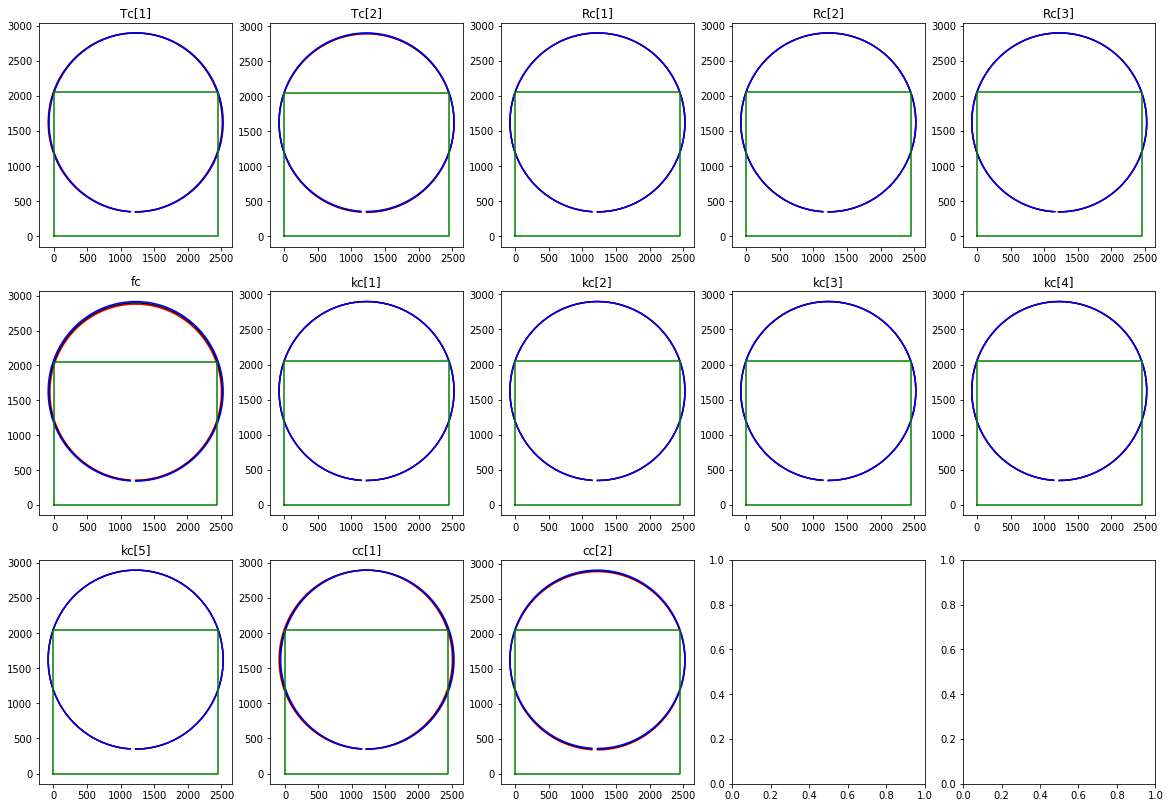

In [22]:
%matplotlib inline

# Get the fiducial choice for camera 1
prefix = "MANIFEST_sim_001_coord_data_camera-1"
params = GetFiducialParameter(prefix)
plateTarget = ReadPlatePos(prefix)
plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)

pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

WIDTH,HEIGHT = 2448,2050

fig,axs = plt.subplots(3,5,figsize=(20,14))
axs = axs.flatten()

for indx,valType,ax in zip(range(13),
                       ['Tc[1]','Tc[2]','Rc[1]','Rc[2]','Rc[3]','fc',
                       'kc[1]','kc[2]','kc[3]','kc[4]','kc[5]','cc[1]','cc[2]'],axs):
    for valRange,color in zip([-1,0,1],['r','k','b']):
        rv = np.zeros(13)
        rv[indx] = valRange
        
        newParams = ChangeFullFiducialParameter(params,rv)
        pixTarget = ConvertPlateToPix(plateTarget,newParams)
        pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
        
        ax.plot(pixFiducial[:,0],pixFiducial[:,1],c=color,ms=0.5)
        
    ax.plot([0,WIDTH,WIDTH,0,0],[0,0,HEIGHT,HEIGHT,0],'g-')
    ax.set_title(valType)

Wait. There are two lessons in the above figures.
- There is no big difference in the image region, as we expected at the first time.
- The estimation of circle from **error-added models** are similar to the above figures, while the estimation from the **fiducial model** is not. This may show that my calculation for fiducial model is something wrong.

params after GetFiducialParameter:  [    0.        -299.408892 -3261.955597] [ 0.097242 -0.097242  1.568608] 7246.376812 [-0.2  0.   0.   0.   0. ] [1224 1025]
params after ChangeFullFiducialParameter:  [   -0.        -299.408892 -3261.955597] [ 0.097242 -0.097242  1.568608] 7246.376812 [-0.2  0.   0.   0.   0. ] [1224 1025]


C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


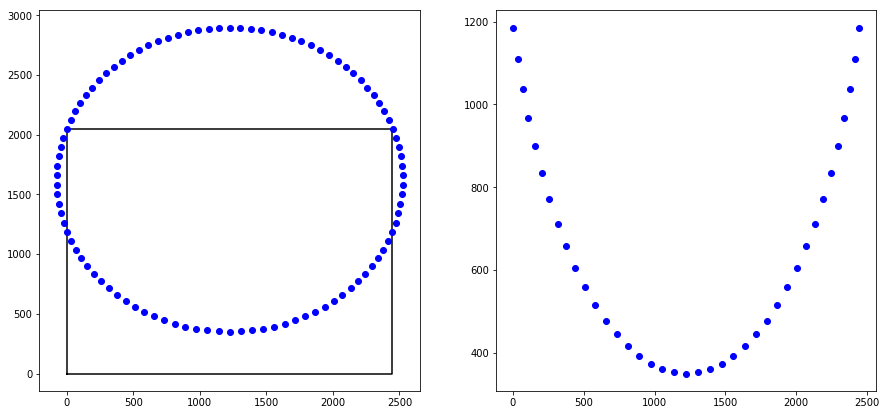

In [23]:
%matplotlib inline

# Get the fiducial choice for camera 1
prefix = "MANIFEST_sim_001_coord_data_camera-1"
params = GetFiducialParameter(prefix)
print("params after GetFiducialParameter: ",params.Tc,params.Rc,params.fc,params.kc,params.cc,flush=True)
plateTarget = ReadPlatePos(prefix)
plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)
pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

WIDTH,HEIGHT = 2448,2050

fig,axs = plt.subplots(1,2,figsize=(15,7))

pixFiducialFidSub = CollectPixWithinFrame(pixFiducialFid,WIDTH,HEIGHT)
circleFid = GetCircle(pixFiducialFidSub)

axs[0].plot(pixFiducialFid[:,0],pixFiducialFid[:,1],'r+')
axs[0].plot([0,WIDTH,WIDTH,0,0],[0,0,HEIGHT,HEIGHT,0],'k-')
axs[1].plot(pixFiducialFidSub[:,0],pixFiducialFidSub[:,1],'r+')

newParam = ChangeFullFiducialParameter(params,np.zeros(13))
print("params after ChangeFullFiducialParameter: ",newParam.Tc,newParam.Rc,newParam.fc,newParam.kc,newParam.cc,flush=True)
pixFiducialNew = ConvertPlateToPix(plateFiducial,newParam)
pixFiducialNewSub = CollectPixWithinFrame(pixFiducialNew,WIDTH,HEIGHT)

axs[0].plot(pixFiducialNew[:,0],pixFiducialNew[:,1],'bo')
axs[1].plot(pixFiducialNewSub[:,0],pixFiducialNewSub[:,1],'bo')

Errrgh, the fiducial model and the ones with **zero** deviation (both should be the same) give different pixel coordinate distributions... Let's solve it!
(Probably, this is the reason why our LSQ fitting has not worked well!!!)

---> The calculation of **Tc[3]** from given **Tc[1-2]** was wrong. It should be $-\sqrt{T_c^2 - T_{c1}^2 - T_{c2}^2}$, not $\sqrt{T_c^2 - T_{c1}^2 - T_{c2}^2}$.

---> Good! Let's go back to previous tests, from the top of this page.

### 2. Check **fc and Rc[3]**

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


<Figure size 432x288 with 0 Axes>

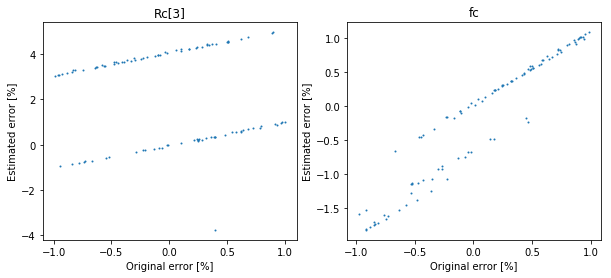

In [46]:
%matplotlib inline

def GetAngle(arrPix,center):
    return np.array(sorted(np.arctan2(arrPix[:,1]-center[1],arrPix[:,0]-center[0]))[:37])

# Get the fiducial choice for camera 1
prefix = "MANIFEST_sim_001_coord_data_camera-1"
params = GetFiducialParameter(prefix)
plateTarget = ReadPlatePos(prefix)
plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)

pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

WIDTH,HEIGHT = 2448,2050

pixFiducialFidSub = CollectPixWithinFrame(pixFiducialFid,WIDTH,HEIGHT)

plt.clf()
fig,axs = plt.subplots(1,2,figsize=(10,4))
axs = axs.flatten()

# Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
Nvar = 100
randVar = np.random.rand(Nvar,13)*2-1.

arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

errBudget = []
for rv,ivar in zip(randVar,range(1,Nvar+1)):
    newParams = ChangeFullFiducialParameter(params,rv)
    pixTarget = ConvertPlateToPix(plateTarget,newParams)
    pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
        
    pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
    plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
    
    circleFid,circleEst = GetCircle(pixFiducialFidSub),GetCircle(pixFiducialSub)
    # Rc[3] = Rc[3]_fid + (angle - angle_fid)
    angleFid,angleEst = GetAngle(pixFiducialFidSub,circleFid[:2]),GetAngle(pixFiducialSub,circleEst[:2])
    arrRcCE.append(np.median(angleEst-angleFid)/params.Rc[2]*100)
    # fc = fc_fid * (radius/radius_fid)
    arrFcE.append((circleEst[2]/circleFid[2]-1.)*100)
    

for ax,orig,est,valType in zip(axs,[arrRcCO,arrFcO],[arrRcCE,arrFcE],["Rc[3]","fc"]):
    ax.scatter(orig,est,s=1,rasterized=True)
    ax.set_title(valType)
    ax.set_xlabel("Original error [%]")
    ax.set_ylabel("Estimated error [%]")
    
plt.savefig("output/rc_fc_positive.pdf",bbox_inches="tight",dpi=150)

Let's summarize up to now.
- The main problem was that I made the wrong calculation for **Tc[3]** from given **Tc[1-2]**. After correcting it, the residue error significantly drops.
- Among three-or-four-round LSQ iterations, three-round iteration gives the best result.
 + This may mean that fitting many parameters at once is better than separating them pieces, since they are nonlinearly correlated in the calculation. ---> How about doing the staggered process again?
 + In best case, **Rc[3]** and **fc** are quite well estimated. **cc[]** estimation have strong correlation to their actual values. **Tc[]** and **Rc[1-2]** have a certain correlation to their actual values. However, **kc[]** are not recovered, just as in the previous machine-learning test.
- The individual estimation of **Rc[3]**, **fc**, **cc[]** by using circles seems as precise as the three-round iteration, but there is an offset. Therefore, there is not so much need for using that method.

Let's try the staggered process again!!

## C. Staggered process revisited
### 1. Extrinsic -> Intrinsic, no iteration

In [49]:
from scipy import optimize as opt

def RecalibrateParameter(arrPlate,arrPix,paramsFid):
    # 1. Initialize two types of parameters:
    # - extrinsic = [Tc[0],Tc[1],Rc[0],Rc[1],Rc[2]]
    # - intrinsic = [fc,kc[0],kc[1],kc[2],kc[3],kc[4],cc[0],cc[1]]
    extFid = np.concatenate([paramsFid.Tc[:2],paramsFid.Rc])
    intFid = np.concatenate([np.array([paramsFid.fc]),paramsFid.kc,paramsFid.cc])
    
    extLP,extHP = extFid*0.99,extFid*1.01
    intLP,intHP = intFid*0.99,intFid*1.01
    
    extLB = np.minimum(extLP,extHP) + np.array([-np.abs(paramsFid.Tc[1]*0.01),0,0,0,0])
    extUB = np.maximum(extLP,extHP) + np.array([np.abs(paramsFid.Tc[1]*0.01),0,0,0,0])
    intLB = np.minimum(intLP,intHP) + np.array([0,0,-1E-6,-1E-6,-1E-6,-1E-6,0,0])
    intUB = np.maximum(intLP,intHP) + np.array([0,0,1E-6,1E-6,1E-6,1E-6,0,0])
    
    # 2. Calibrate extrinsic --> intrinsic
    # Here, calibrate at once.
    extrinsic = opt.least_squares(ResidueChangeExtrinsic,extFid,
                                  args=(arrPlate,arrPix,intFid),bounds=(extLB,extUB),
                                  ftol=1E-16,xtol=1E-16).x
    intrinsic = opt.least_squares(ResidueChangeIntrinsic,intFid,
                                  args=(arrPlate,arrPix,extrinsic),bounds=(intLB,intUB),
                                  ftol=1E-16,xtol=1E-16).x

    newParam = ConstructParameter(extrinsic,intrinsic)
    print("Result of newParam: ",newParam.Tc,newParam.Rc,newParam.fc,newParam.kc,newParam.cc,flush=True)
    return newParam


def ConstructParameter(extrinsic,intrinsic):
    params = Parameter()
    TcSq = params.Tc[0]**2 + params.Tc[1]**2 + params.Tc[2]**2
    params.Tc = np.array([extrinsic[0],extrinsic[1],-np.sqrt(TcSq - extrinsic[0]**2 - extrinsic[1]**2)])
    params.Rc = np.copy(extrinsic[2:])
    params.fc = intrinsic[0]
    params.kc = np.copy(intrinsic[1:6])
    params.cc = np.copy(intrinsic[6:])
    return params

def ResidueChangeExtrinsic(extrinsic,arrPlate,arrPix,intrinsic):
    params = ConstructParameter(extrinsic,intrinsic)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

def ResidueChangeIntrinsic(intrinsic,arrPlate,arrPix,extrinsic):
    params = ConstructParameter(extrinsic,intrinsic)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


Result of newParam:  [ -4.58711173e-01  -3.01417527e+02  -3.26177057e+03] [ 0.09821442 -0.09821442  1.57377242] 7305.61828614 [ -1.98542817e-01   8.25858749e-07   1.00000000e-06  -1.00000000e-06
  -4.85769943e-07] [ 1223.94756435  1028.13238415]
Fiducial Tc[1]: -299.408892, estimated Tc[1]: -301.417527, error: 0.670867 %
Fiducial Rc[3]: 1.568608, estimated Rc[3]: 1.573772, error: 0.329236 %
Fiducial fc: 7246.376812, estimated fc: 7305.618286, error: 0.817532 %
Result of newParam:  [ -2.10634745e+00  -2.97291142e+02  -3.26214861e+03] [ 0.09626958 -0.09626958  1.56817215] 7186.64787302 [ -2.02000000e-01  -9.99698217e-07  -1.00000000e-06   1.00000000e-06
  -9.27721523e-07] [ 1224.05534505  1022.55559349]
Fiducial Tc[1]: -299.408892, estimated Tc[1]: -297.291142, error: -0.707310 %
Fiducial Rc[3]: 1.568608, estimated Rc[3]: 1.568172, error: -0.027786 %
Fiducial fc: 7246.376812, estimated fc: 7186.647873, error: -0.824259 %
Result of newParam:  [ -2.05881078e+00  -2.97215956e+02  -3.2621554

<Figure size 432x288 with 0 Axes>

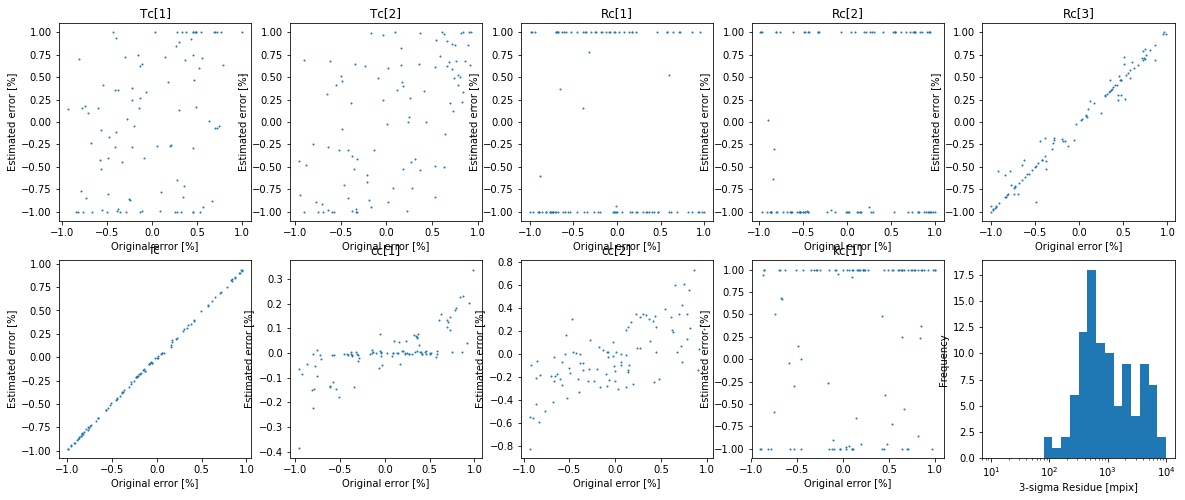

In [50]:
%matplotlib inline

# Get the fiducial choice for camera 1
prefix = "MANIFEST_sim_001_coord_data_camera-1"
params = GetFiducialParameter(prefix)
plateTarget = ReadPlatePos(prefix)
plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)

pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

WIDTH,HEIGHT = 2448,2050

plt.clf()
fig,axs = plt.subplots(2,5,figsize=(20,8))
axs = axs.flatten()

# Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
Nvar = 100
randVar = np.random.rand(Nvar,13)*2-1.

arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

errBudget = []
for rv,ivar in zip(randVar,range(1,Nvar+1)):
    newParams = ChangeFullFiducialParameter(params,rv)
    pixTarget = ConvertPlateToPix(plateTarget,newParams)
    pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
        
    pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
    plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
    
    estParams = RecalibrateParameter(plateFiducialSub,pixFiducialSub,params)
    arrTcAE.append(estParams.Tc[0]/params.Tc[1]*100)
    arrTcBE.append((estParams.Tc[1]-params.Tc[1])/params.Tc[1]*100)
    print("Fiducial Tc[1]: %f, estimated Tc[1]: %f, error: %f %%" % (params.Tc[1],estParams.Tc[1],arrTcBE[-1]),flush=True)
    arrRcAE.append((estParams.Rc[0]-params.Rc[0])/params.Rc[0]*100)
    arrRcBE.append((estParams.Rc[1]-params.Rc[1])/params.Rc[1]*100)
    arrRcCE.append((estParams.Rc[2]-params.Rc[2])/params.Rc[2]*100)
    print("Fiducial Rc[3]: %f, estimated Rc[3]: %f, error: %f %%" % (params.Rc[2],estParams.Rc[2],arrRcCE[-1]),flush=True)
    arrFcE.append((estParams.fc-params.fc)/params.fc*100)
    print("Fiducial fc: %f, estimated fc: %f, error: %f %%" % (params.fc,estParams.fc,arrFcE[-1]),flush=True)
    arrCcAE.append((estParams.cc[0]-params.cc[0])/params.cc[0]*100)
    arrCcBE.append((estParams.cc[1]-params.cc[1])/params.cc[1]*100)
    arrKcAE.append((estParams.kc[0]-params.kc[0])/params.kc[0]*100)

    estPixTarget = ConvertPlateToPix(plateTarget,estParams)
    residues = np.sqrt((estPixTarget[:,0]-pixTarget[:,0])**2 + (estPixTarget[:,1]-pixTarget[:,1])**2)*1E3
    
    errBudget.append(np.percentile(residues,99.865))
    
print("Error in Rc[3]: ",arrRcCE,flush=True)


for ax,orig,est,valType in zip(axs[:-1],
                                [arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO],
                              [arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE],
                              ["Tc[1]","Tc[2]","Rc[1]","Rc[2]","Rc[3]","fc","cc[1]","cc[2]","kc[1]"]):
    ax.scatter(orig,est,s=1,rasterized=True)
    ax.set_title(valType)
    ax.set_xlabel("Original error [%]")
    ax.set_ylabel("Estimated error [%]")
    
axs[-1].hist(errBudget,bins=np.logspace(1,4,21))
axs[-1].set_xlabel("3-sigma Residue [mpix]")
axs[-1].set_xscale("log")
axs[-1].set_ylabel("Frequency")
plt.savefig("output/extrinsicFirst_noIterate.pdf",bbox_inches="tight",dpi=150)

### 2. Intrinsic --> Extrinsic, no iteration.

In [51]:
from scipy import optimize as opt

def RecalibrateParameter(arrPlate,arrPix,paramsFid):
    # 1. Initialize two types of parameters:
    # - extrinsic = [Tc[0],Tc[1],Rc[0],Rc[1],Rc[2]]
    # - intrinsic = [fc,kc[0],kc[1],kc[2],kc[3],kc[4],cc[0],cc[1]]
    extFid = np.concatenate([paramsFid.Tc[:2],paramsFid.Rc])
    intFid = np.concatenate([np.array([paramsFid.fc]),paramsFid.kc,paramsFid.cc])
    
    extLP,extHP = extFid*0.99,extFid*1.01
    intLP,intHP = intFid*0.99,intFid*1.01
    
    extLB = np.minimum(extLP,extHP) + np.array([-np.abs(paramsFid.Tc[1]*0.01),0,0,0,0])
    extUB = np.maximum(extLP,extHP) + np.array([np.abs(paramsFid.Tc[1]*0.01),0,0,0,0])
    intLB = np.minimum(intLP,intHP) + np.array([0,0,-1E-6,-1E-6,-1E-6,-1E-6,0,0])
    intUB = np.maximum(intLP,intHP) + np.array([0,0,1E-6,1E-6,1E-6,1E-6,0,0])
    
    # 2. Calibrate intrinsic --> extrinsic
    # Here, calibrate at once.
    intrinsic = opt.least_squares(ResidueChangeIntrinsic,intFid,
                                  args=(arrPlate,arrPix,extFid),bounds=(intLB,intUB),
                                  ftol=1E-16,xtol=1E-16).x
    extrinsic = opt.least_squares(ResidueChangeExtrinsic,extFid,
                                  args=(arrPlate,arrPix,intrinsic),bounds=(extLB,extUB),
                                  ftol=1E-16,xtol=1E-16).x

    newParam = ConstructParameter(extrinsic,intrinsic)
    print("Result of newParam: ",newParam.Tc,newParam.Rc,newParam.fc,newParam.kc,newParam.cc,flush=True)
    return newParam

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


Result of newParam:  [ -1.57872398e+00  -2.99389786e+02  -3.26195697e+03] [ 0.09638866 -0.09715215  1.5650488 ] 7210.52022086 [ -1.98000000e-01   9.77287568e-07   1.00000000e-06   1.00000000e-06
  -1.84052356e-07] [ 1222.29165065  1025.57759155]
Fiducial Tc[1]: -299.408892, estimated Tc[1]: -299.389786, error: -0.006381 %
Fiducial Rc[3]: 1.568608, estimated Rc[3]: 1.565049, error: -0.226902 %
Fiducial fc: 7246.376812, estimated fc: 7210.520221, error: -0.494821 %
Result of newParam:  [  2.96437996e+00  -2.99392334e+02  -3.26195577e+03] [ 0.09626958 -0.09821442  1.57672952] 7254.61259986 [ -1.98000089e-01   5.34516937e-07  -1.00000000e-06  -1.00000000e-06
   9.46468113e-07] [ 1229.47134099  1033.33559488]
Fiducial Tc[1]: -299.408892, estimated Tc[1]: -299.392334, error: -0.005530 %
Fiducial Rc[3]: 1.568608, estimated Rc[3]: 1.576730, error: 0.517753 %
Fiducial fc: 7246.376812, estimated fc: 7254.612600, error: 0.113654 %
Result of newParam:  [  2.99408790e+00  -2.99395884e+02  -3.261955

<Figure size 432x288 with 0 Axes>

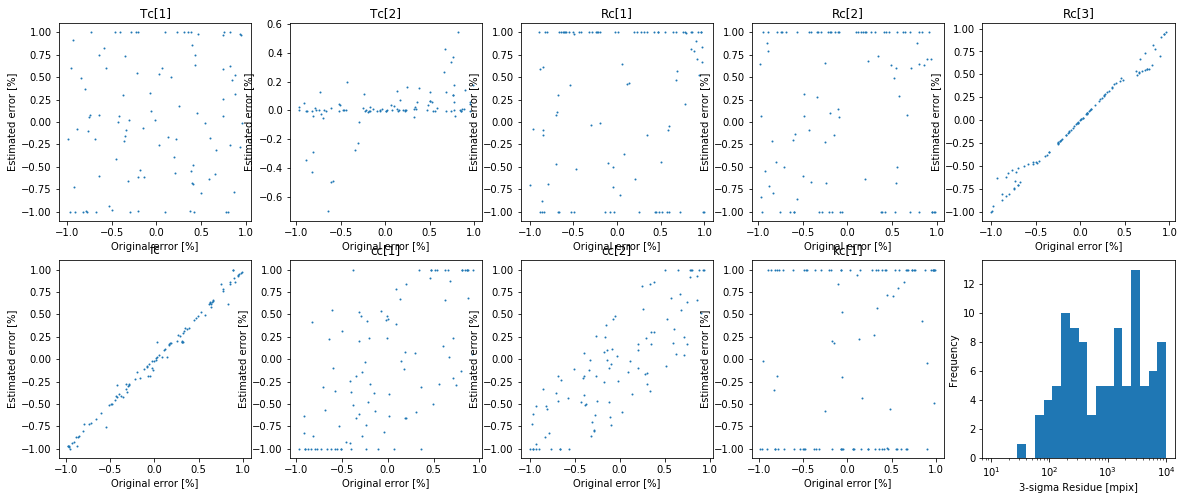

In [52]:
%matplotlib inline

# Get the fiducial choice for camera 1
prefix = "MANIFEST_sim_001_coord_data_camera-1"
params = GetFiducialParameter(prefix)
plateTarget = ReadPlatePos(prefix)
plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)

pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

WIDTH,HEIGHT = 2448,2050

plt.clf()
fig,axs = plt.subplots(2,5,figsize=(20,8))
axs = axs.flatten()

# Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
Nvar = 100
randVar = np.random.rand(Nvar,13)*2-1.

arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

errBudget = []
for rv,ivar in zip(randVar,range(1,Nvar+1)):
    newParams = ChangeFullFiducialParameter(params,rv)
    pixTarget = ConvertPlateToPix(plateTarget,newParams)
    pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
        
    pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
    plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
    
    estParams = RecalibrateParameter(plateFiducialSub,pixFiducialSub,params)
    arrTcAE.append(estParams.Tc[0]/params.Tc[1]*100)
    arrTcBE.append((estParams.Tc[1]-params.Tc[1])/params.Tc[1]*100)
    print("Fiducial Tc[1]: %f, estimated Tc[1]: %f, error: %f %%" % (params.Tc[1],estParams.Tc[1],arrTcBE[-1]),flush=True)
    arrRcAE.append((estParams.Rc[0]-params.Rc[0])/params.Rc[0]*100)
    arrRcBE.append((estParams.Rc[1]-params.Rc[1])/params.Rc[1]*100)
    arrRcCE.append((estParams.Rc[2]-params.Rc[2])/params.Rc[2]*100)
    print("Fiducial Rc[3]: %f, estimated Rc[3]: %f, error: %f %%" % (params.Rc[2],estParams.Rc[2],arrRcCE[-1]),flush=True)
    arrFcE.append((estParams.fc-params.fc)/params.fc*100)
    print("Fiducial fc: %f, estimated fc: %f, error: %f %%" % (params.fc,estParams.fc,arrFcE[-1]),flush=True)
    arrCcAE.append((estParams.cc[0]-params.cc[0])/params.cc[0]*100)
    arrCcBE.append((estParams.cc[1]-params.cc[1])/params.cc[1]*100)
    arrKcAE.append((estParams.kc[0]-params.kc[0])/params.kc[0]*100)

    estPixTarget = ConvertPlateToPix(plateTarget,estParams)
    residues = np.sqrt((estPixTarget[:,0]-pixTarget[:,0])**2 + (estPixTarget[:,1]-pixTarget[:,1])**2)*1E3
    
    errBudget.append(np.percentile(residues,99.865))
    
print("Error in Rc[3]: ",arrRcCE,flush=True)


for ax,orig,est,valType in zip(axs[:-1],
                                [arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO],
                              [arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE],
                              ["Tc[1]","Tc[2]","Rc[1]","Rc[2]","Rc[3]","fc","cc[1]","cc[2]","kc[1]"]):
    ax.scatter(orig,est,s=1,rasterized=True)
    ax.set_title(valType)
    ax.set_xlabel("Original error [%]")
    ax.set_ylabel("Estimated error [%]")
    
axs[-1].hist(errBudget,bins=np.logspace(1,4,21))
axs[-1].set_xlabel("3-sigma Residue [mpix]")
axs[-1].set_xscale("log")
axs[-1].set_ylabel("Frequency")
plt.savefig("output/intrinsicFirst_noIterate.pdf",bbox_inches="tight",dpi=150)

### 3. Extrinsic <--> Intrinsic

In [53]:
from scipy import optimize as opt

def RecalibrateParameter(arrPlate,arrPix,paramsFid):
    # 1. Initialize two types of parameters:
    # - extrinsic = [Tc[0],Tc[1],Rc[0],Rc[1],Rc[2]]
    # - intrinsic = [fc,kc[0],kc[1],kc[2],kc[3],kc[4],cc[0],cc[1]]
    extFid = np.concatenate([paramsFid.Tc[:2],paramsFid.Rc])
    intFid = np.concatenate([np.array([paramsFid.fc]),paramsFid.kc,paramsFid.cc])
    
    extLP,extHP = extFid*0.99,extFid*1.01
    intLP,intHP = intFid*0.99,intFid*1.01
    
    extLB = np.minimum(extLP,extHP) + np.array([-np.abs(paramsFid.Tc[1]*0.01),0,0,0,0])
    extUB = np.maximum(extLP,extHP) + np.array([np.abs(paramsFid.Tc[1]*0.01),0,0,0,0])
    intLB = np.minimum(intLP,intHP) + np.array([0,0,-1E-6,-1E-6,-1E-6,-1E-6,0,0])
    intUB = np.maximum(intLP,intHP) + np.array([0,0,1E-6,1E-6,1E-6,1E-6,0,0])
    
    # 2. Calibrate extrinsic --> intrinsic by repeating
    extrinsic,intrinsic = np.copy(extFid),np.copy(intFid)
    for iteration in range(100):
        extOld,intOld = np.copy(extrinsic),np.copy(intrinsic)
        
        extrinsic = opt.least_squares(ResidueChangeExtrinsic,extOld,
                                      args=(arrPlate,arrPix,intOld),bounds=(extLB,extUB),
                                      ftol=1E-16,xtol=1E-16).x
        intrinsic = opt.least_squares(ResidueChangeIntrinsic,intOld,
                                      args=(arrPlate,arrPix,extrinsic),bounds=(intLB,intUB),
                                      ftol=1E-16,xtol=1E-16).x
        
        err = max(np.amax(np.abs((extrinsic-extOld)/extOld)),np.amax(np.abs((intrinsic-intOld)/intOld)))
        if err < 1E-6:
            break

    newParam = ConstructParameter(extrinsic,intrinsic)
    print("Result of newParam: ",newParam.Tc,newParam.Rc,newParam.fc,newParam.kc,newParam.cc,flush=True)
    return newParam

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


Result of newParam:  [ -1.22537327e-02  -2.96479289e+02  -3.26222317e+03] [ 0.09821277 -0.09730696  1.57230341] 7188.65314734 [ -1.98962887e-01  -9.77225562e-07  -9.99900268e-07  -9.99900151e-07
  -9.99453212e-07] [ 1224.02907871  1019.94327968]
Fiducial Tc[1]: -299.408892, estimated Tc[1]: -296.479289, error: -0.978462 %
Fiducial Rc[3]: 1.568608, estimated Rc[3]: 1.572303, error: 0.235585 %
Fiducial fc: 7246.376812, estimated fc: 7188.653147, error: -0.796587 %
Result of newParam:  [ -2.99408890e+00  -3.02035213e+02  -3.26171209e+03] [ 0.09626958 -0.09711348  1.57419233] 7210.45566045 [ -1.99675008e-01   9.99998985e-07   9.99999196e-07  -9.99999920e-07
   9.99998811e-07] [ 1228.88979267  1023.45817161]
Fiducial Tc[1]: -299.408892, estimated Tc[1]: -302.035213, error: 0.877169 %
Fiducial Rc[3]: 1.568608, estimated Rc[3]: 1.574192, error: 0.356005 %
Fiducial fc: 7246.376812, estimated fc: 7210.455660, error: -0.495712 %
Result of newParam:  [ -8.55389680e-01  -2.98466540e+02  -3.2620418

<Figure size 432x288 with 0 Axes>

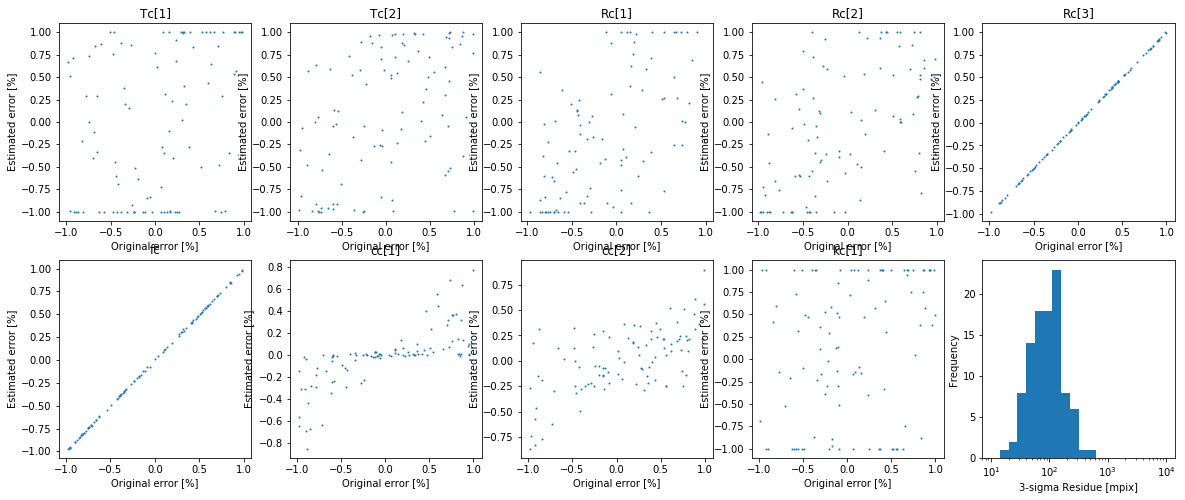

In [54]:
%matplotlib inline

# Get the fiducial choice for camera 1
prefix = "MANIFEST_sim_001_coord_data_camera-1"
params = GetFiducialParameter(prefix)
plateTarget = ReadPlatePos(prefix)
plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)

pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

WIDTH,HEIGHT = 2448,2050

plt.clf()
fig,axs = plt.subplots(2,5,figsize=(20,8))
axs = axs.flatten()

# Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
Nvar = 100
randVar = np.random.rand(Nvar,13)*2-1.

arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

errBudget = []
for rv,ivar in zip(randVar,range(1,Nvar+1)):
    newParams = ChangeFullFiducialParameter(params,rv)
    pixTarget = ConvertPlateToPix(plateTarget,newParams)
    pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
        
    pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
    plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
    
    estParams = RecalibrateParameter(plateFiducialSub,pixFiducialSub,params)
    arrTcAE.append(estParams.Tc[0]/params.Tc[1]*100)
    arrTcBE.append((estParams.Tc[1]-params.Tc[1])/params.Tc[1]*100)
    print("Fiducial Tc[1]: %f, estimated Tc[1]: %f, error: %f %%" % (params.Tc[1],estParams.Tc[1],arrTcBE[-1]),flush=True)
    arrRcAE.append((estParams.Rc[0]-params.Rc[0])/params.Rc[0]*100)
    arrRcBE.append((estParams.Rc[1]-params.Rc[1])/params.Rc[1]*100)
    arrRcCE.append((estParams.Rc[2]-params.Rc[2])/params.Rc[2]*100)
    print("Fiducial Rc[3]: %f, estimated Rc[3]: %f, error: %f %%" % (params.Rc[2],estParams.Rc[2],arrRcCE[-1]),flush=True)
    arrFcE.append((estParams.fc-params.fc)/params.fc*100)
    print("Fiducial fc: %f, estimated fc: %f, error: %f %%" % (params.fc,estParams.fc,arrFcE[-1]),flush=True)
    arrCcAE.append((estParams.cc[0]-params.cc[0])/params.cc[0]*100)
    arrCcBE.append((estParams.cc[1]-params.cc[1])/params.cc[1]*100)
    arrKcAE.append((estParams.kc[0]-params.kc[0])/params.kc[0]*100)

    estPixTarget = ConvertPlateToPix(plateTarget,estParams)
    residues = np.sqrt((estPixTarget[:,0]-pixTarget[:,0])**2 + (estPixTarget[:,1]-pixTarget[:,1])**2)*1E3
    
    errBudget.append(np.percentile(residues,99.865))
    
print("Error in Rc[3]: ",arrRcCE,flush=True)


for ax,orig,est,valType in zip(axs[:-1],
                                [arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO],
                              [arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE],
                              ["Tc[1]","Tc[2]","Rc[1]","Rc[2]","Rc[3]","fc","cc[1]","cc[2]","kc[1]"]):
    ax.scatter(orig,est,s=1,rasterized=True)
    ax.set_title(valType)
    ax.set_xlabel("Original error [%]")
    ax.set_ylabel("Estimated error [%]")
    
axs[-1].hist(errBudget,bins=np.logspace(1,4,21))
axs[-1].set_xlabel("3-sigma Residue [mpix]")
axs[-1].set_xscale("log")
axs[-1].set_ylabel("Frequency")
plt.savefig("output/extrinsicFirst_iterate.pdf",bbox_inches="tight",dpi=150)

### 4. Intrinsic <--> Extrinsic

In [55]:
from scipy import optimize as opt

def RecalibrateParameter(arrPlate,arrPix,paramsFid):
    # 1. Initialize two types of parameters:
    # - extrinsic = [Tc[0],Tc[1],Rc[0],Rc[1],Rc[2]]
    # - intrinsic = [fc,kc[0],kc[1],kc[2],kc[3],kc[4],cc[0],cc[1]]
    extFid = np.concatenate([paramsFid.Tc[:2],paramsFid.Rc])
    intFid = np.concatenate([np.array([paramsFid.fc]),paramsFid.kc,paramsFid.cc])
    
    extLP,extHP = extFid*0.99,extFid*1.01
    intLP,intHP = intFid*0.99,intFid*1.01
    
    extLB = np.minimum(extLP,extHP) + np.array([-np.abs(paramsFid.Tc[1]*0.01),0,0,0,0])
    extUB = np.maximum(extLP,extHP) + np.array([np.abs(paramsFid.Tc[1]*0.01),0,0,0,0])
    intLB = np.minimum(intLP,intHP) + np.array([0,0,-1E-6,-1E-6,-1E-6,-1E-6,0,0])
    intUB = np.maximum(intLP,intHP) + np.array([0,0,1E-6,1E-6,1E-6,1E-6,0,0])
    
    # 2. Calibrate intrinsic --> extrinsic by repeating
    extrinsic,intrinsic = np.copy(extFid),np.copy(intFid)
    for iteration in range(100):
        extOld,intOld = np.copy(extrinsic),np.copy(intrinsic)
        
        intrinsic = opt.least_squares(ResidueChangeIntrinsic,intOld,
                                      args=(arrPlate,arrPix,extOld),bounds=(intLB,intUB),
                                      ftol=1E-16,xtol=1E-16).x
        extrinsic = opt.least_squares(ResidueChangeExtrinsic,extOld,
                                      args=(arrPlate,arrPix,intrinsic),bounds=(extLB,extUB),
                                      ftol=1E-16,xtol=1E-16).x

        err = max(np.amax(np.abs((extrinsic-extOld)/extOld)),np.amax(np.abs((intrinsic-intOld)/intOld)))
        if err < 1E-6:
            break

    newParam = ConstructParameter(extrinsic,intrinsic)
    print("Result of newParam: ",newParam.Tc,newParam.Rc,newParam.fc,newParam.kc,newParam.cc,flush=True)
    return newParam

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


Result of newParam:  [ -2.99404257e+00  -2.99551765e+02  -3.26194111e+03] [ 0.09791712 -0.0964986   1.55684747] 7275.77903541 [ -2.02000000e-01  -9.99900000e-07  -9.99900000e-07  -9.99900000e-07
  -8.56344787e-07] [ 1218.93723169  1015.18329582]
Fiducial Tc[1]: -299.408892, estimated Tc[1]: -299.551765, error: 0.047718 %
Fiducial Rc[3]: 1.568608, estimated Rc[3]: 1.556847, error: -0.749743 %
Fiducial fc: 7246.376812, estimated fc: 7275.779035, error: 0.405751 %
Result of newParam:  [  2.99109861e+00  -2.99572407e+02  -3.26193921e+03] [ 0.09728237 -0.09821442  1.58213599] 7184.38458593 [ -2.00648152e-01  -9.99900704e-07  -9.99998412e-07  -9.99998545e-07
  -9.98978550e-07] [ 1231.88666696  1032.11113147]
Fiducial Tc[1]: -299.408892, estimated Tc[1]: -299.572407, error: 0.054612 %
Fiducial Rc[3]: 1.568608, estimated Rc[3]: 1.582136, error: 0.862420 %
Fiducial fc: 7246.376812, estimated fc: 7184.384586, error: -0.855493 %
Result of newParam:  [  1.93265852e+00  -2.99569236e+02  -3.26194030

<Figure size 432x288 with 0 Axes>

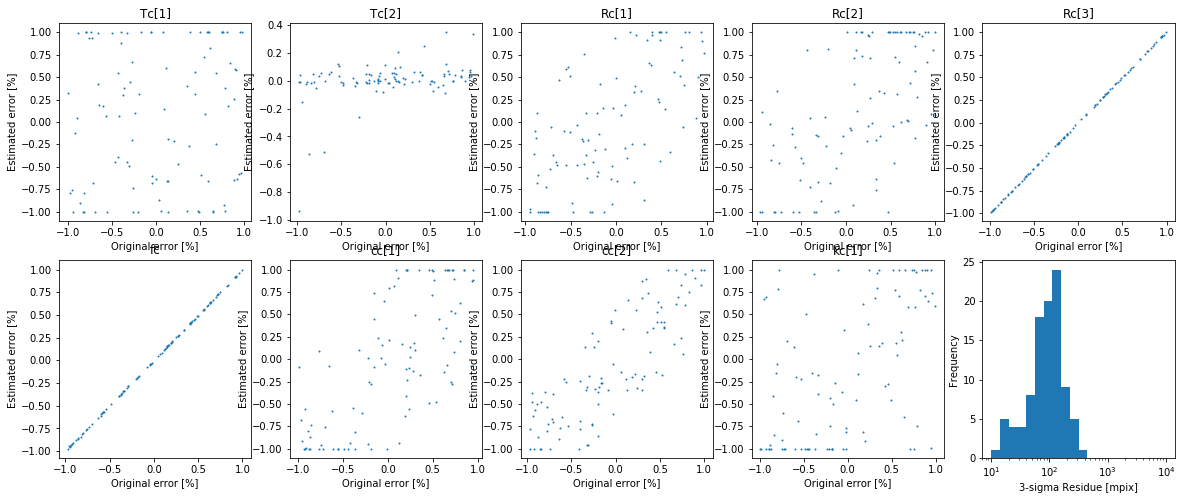

In [57]:
%matplotlib inline

# Get the fiducial choice for camera 1
prefix = "MANIFEST_sim_001_coord_data_camera-1"
params = GetFiducialParameter(prefix)
plateTarget = ReadPlatePos(prefix)
plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)

pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

WIDTH,HEIGHT = 2448,2050

plt.clf()
fig,axs = plt.subplots(2,5,figsize=(20,8))
axs = axs.flatten()

# Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
Nvar = 100
randVar = np.random.rand(Nvar,13)*2-1.

arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

errBudget = []
for rv,ivar in zip(randVar,range(1,Nvar+1)):
    newParams = ChangeFullFiducialParameter(params,rv)
    pixTarget = ConvertPlateToPix(plateTarget,newParams)
    pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
        
    pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
    plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
    
    estParams = RecalibrateParameter(plateFiducialSub,pixFiducialSub,params)
    arrTcAE.append(estParams.Tc[0]/params.Tc[1]*100)
    arrTcBE.append((estParams.Tc[1]-params.Tc[1])/params.Tc[1]*100)
    print("Fiducial Tc[1]: %f, estimated Tc[1]: %f, error: %f %%" % (params.Tc[1],estParams.Tc[1],arrTcBE[-1]),flush=True)
    arrRcAE.append((estParams.Rc[0]-params.Rc[0])/params.Rc[0]*100)
    arrRcBE.append((estParams.Rc[1]-params.Rc[1])/params.Rc[1]*100)
    arrRcCE.append((estParams.Rc[2]-params.Rc[2])/params.Rc[2]*100)
    print("Fiducial Rc[3]: %f, estimated Rc[3]: %f, error: %f %%" % (params.Rc[2],estParams.Rc[2],arrRcCE[-1]),flush=True)
    arrFcE.append((estParams.fc-params.fc)/params.fc*100)
    print("Fiducial fc: %f, estimated fc: %f, error: %f %%" % (params.fc,estParams.fc,arrFcE[-1]),flush=True)
    arrCcAE.append((estParams.cc[0]-params.cc[0])/params.cc[0]*100)
    arrCcBE.append((estParams.cc[1]-params.cc[1])/params.cc[1]*100)
    arrKcAE.append((estParams.kc[0]-params.kc[0])/params.kc[0]*100)

    estPixTarget = ConvertPlateToPix(plateTarget,estParams)
    residues = np.sqrt((estPixTarget[:,0]-pixTarget[:,0])**2 + (estPixTarget[:,1]-pixTarget[:,1])**2)*1E3
    
    errBudget.append(np.percentile(residues,99.865))
    
print("Error in Rc[3]: ",arrRcCE,flush=True)


for ax,orig,est,valType in zip(axs[:-1],
                                [arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO],
                              [arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE],
                              ["Tc[1]","Tc[2]","Rc[1]","Rc[2]","Rc[3]","fc","cc[1]","cc[2]","kc[1]"]):
    ax.scatter(orig,est,s=1,rasterized=True)
    ax.set_title(valType)
    ax.set_xlabel("Original error [%]")
    ax.set_ylabel("Estimated error [%]")
    
axs[-1].hist(errBudget,bins=np.logspace(1,4,21))
axs[-1].set_xlabel("3-sigma Residue [mpix]")
axs[-1].set_xscale("log")
axs[-1].set_ylabel("Frequency")
plt.savefig("output/intrinsicFirst_iterate.pdf",bbox_inches="tight",dpi=150)

Let's summarize:
- Single iterations of intrinsic->extrinsic and extrinsic->intrinsic are worse than 3-round iteration that we did before.
- However, multiple iterations of intrinsic<->extrinsic and extrinsic<->intrinsic are better than 3-round iteration.
 + Extrinsic <--> intrinsic is better than intrinsic <--> extrinsic, probably because there are more parameters that can be well tuned in the extrinsic parameters (**fc** and **cc[]**).
 + This may mean that multiple iterations of 3-round iteration may bring better result.
- Up to now, the best result comes from multiple extrinsic <--> intrinsic iterations, whose $3\sigma$ residue is about 100 mpix on average (~50 microns). This is beyond the requirement (30 microns).

## A.1. New ordered LSQ fitting revisited (multiple iteration)

In [63]:
def TestFitting(filename):

    # Get the fiducial choice for camera 1
    prefix = "MANIFEST_sim_001_coord_data_camera-1"
    params = GetFiducialParameter(prefix)
    plateTarget = ReadPlatePos(prefix)
    plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)

    pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

    WIDTH,HEIGHT = 2448,2050

    plt.clf()
    fig,axs = plt.subplots(2,5,figsize=(20,8))
    axs = axs.flatten()

    # Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
    Nvar = 100
    randVar = np.random.rand(Nvar,13)*2-1.

    arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
    arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

    errBudget = []
    for rv,ivar in zip(randVar,range(1,Nvar+1)):
        newParams = ChangeFullFiducialParameter(params,rv)
        pixTarget = ConvertPlateToPix(plateTarget,newParams)
        pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
        
        pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
        plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
    
        estParams = RecalibrateParameter(plateFiducialSub,pixFiducialSub,params)
        arrTcAE.append(estParams.Tc[0]/params.Tc[1]*100)
        arrTcBE.append((estParams.Tc[1]-params.Tc[1])/params.Tc[1]*100)
        arrRcAE.append((estParams.Rc[0]-params.Rc[0])/params.Rc[0]*100)
        arrRcBE.append((estParams.Rc[1]-params.Rc[1])/params.Rc[1]*100)
        arrRcCE.append((estParams.Rc[2]-params.Rc[2])/params.Rc[2]*100)
        arrFcE.append((estParams.fc-params.fc)/params.fc*100)
        arrCcAE.append((estParams.cc[0]-params.cc[0])/params.cc[0]*100)
        arrCcBE.append((estParams.cc[1]-params.cc[1])/params.cc[1]*100)
        arrKcAE.append((estParams.kc[0]-params.kc[0])/params.kc[0]*100)

        estPixTarget = ConvertPlateToPix(plateTarget,estParams)
        residues = np.sqrt((estPixTarget[:,0]-pixTarget[:,0])**2 + (estPixTarget[:,1]-pixTarget[:,1])**2)*1E3
    
        errBudget.append(np.percentile(residues,99.865))
        print("\r","Done sample %3d" % (ivar),end='',flush=True)

    for ax,orig,est,valType in zip(axs[:-1],
                                   [arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO],
                                   [arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE],
                                   ["Tc[1]","Tc[2]","Rc[1]","Rc[2]","Rc[3]","fc","cc[1]","cc[2]","kc[1]"]):
        ax.scatter(orig,est,s=1,rasterized=True)
        ax.set_title(valType)
        ax.set_xlabel("Original error [%]")
        ax.set_ylabel("Estimated error [%]")
    
    axs[-1].hist(errBudget,bins=np.logspace(1,4,21))
    axs[-1].set_xlabel("3-sigma Residue [mpix]")
    axs[-1].set_xscale("log")
    axs[-1].set_ylabel("Frequency")
    plt.savefig("output/%s" % (filename),bbox_inches="tight",dpi=150)

### 1. **Tc[], Rc[3], fc, cc[]** first

In [59]:
from scipy import optimize as opt

def RecalibrateParameter(arrPlate,arrPix,paramsFid):
    # 1. Initialize three types of parameters by using fiducial choice:
    # - criticalParam = [Tc[0],Tc[1],Rc[2],fc,cc[0],cc[1]]
    # - probableParam = [Rc[0],Rc[1],kc[0]]
    # - redundantParam = [kc[1],kc[2],kc[3],kc[4]]
    criticalFid = np.array([paramsFid.Tc[0],paramsFid.Tc[1],paramsFid.Rc[2],paramsFid.fc,paramsFid.cc[0],paramsFid.cc[1]],dtype=np.float64)
    probableFid = np.array([paramsFid.Rc[0],paramsFid.Rc[1],paramsFid.kc[0]],dtype=np.float64)
    redundantFid = np.copy(paramsFid.kc[1:])
        
    criticalLP,criticalHP = criticalFid*0.99,criticalFid*1.01
    probableLP,probableHP = probableFid*0.99,probableFid*1.01
    
    criticalLB = np.minimum(criticalLP,criticalHP) + np.array([-np.abs(paramsFid.Tc[1]*0.01),0.,0.,0.,0.,0.],dtype=np.float64)
    criticalUB = np.maximum(criticalLP,criticalHP) + np.array([np.abs(paramsFid.Tc[1]*0.01),0.,0.,0.,0.,0.],dtype=np.float64)
    probableLB,probableUB = np.minimum(probableLP,probableHP),np.maximum(probableLP,probableHP)
    redundantLB,redundantUB = -1E-6 * np.ones(4), 1E-6 * np.ones(4)
    
    # 2. Calibrate criticalParam --> probableParam --> redundantParam
    # Here, calibrate multiple times
    critical,probable,redundant = np.copy(criticalFid),np.copy(probableFid),np.copy(redundantFid)
    for iteration in range(100):
        criticalOld,probableOld,redundantOld = np.copy(critical),np.copy(probable),np.copy(redundant)
        critical = opt.least_squares(ResidueChangeCritical,criticalOld,
                                     args=(arrPlate,arrPix,probableOld,redundantOld),
                                     bounds=(criticalLB,criticalUB),
                                     ftol=1E-16,xtol=1E-16).x
        probable = opt.least_squares(ResidueChangeProbable,probableOld,
                                     args=(arrPlate,arrPix,critical,redundantOld),
                                     bounds=(probableLB,probableUB),
                                     ftol=1E-16,xtol=1E-16).x
        redundant = opt.least_squares(ResidueChangeRedundant,redundantOld,
                                      args=(arrPlate,arrPix,critical,probable),
                                      bounds=(redundantLB,redundantUB),
                                      ftol=1E-16,xtol=1E-16).x
        
        err = max(np.amax(np.abs((critical-criticalOld)/criticalOld)),
                  np.amax(np.abs((probable-probableOld)/probableOld)),
                  np.amax(np.abs((redundant-redundantOld)/redundantOld)))
        if err < 1E-6:
            break

    newParam = ConstructParameter(critical,probable,redundant)
    return newParam


def ConstructParameter(criticalParam,probableParam,redundantParam):
    params = Parameter()
    TcSq = params.Tc[0]**2 + params.Tc[1]**2 + params.Tc[2]**2
    params.Tc = np.array([criticalParam[0],criticalParam[1],-np.sqrt(TcSq - criticalParam[0]**2 - criticalParam[1]**2)])
    params.Rc = np.array([probableParam[0],probableParam[1],criticalParam[2]])
    params.fc = criticalParam[3]
    params.kc = np.array([probableParam[2],redundantParam[0],redundantParam[1],redundantParam[2],redundantParam[3]])
    params.cc = np.array([criticalParam[4],criticalParam[5]])
    return params

def ResidueChangeCritical(criticalParam,arrPlate,arrPix,probableParam,redundantParam):
    params = ConstructParameter(criticalParam,probableParam,redundantParam)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

def ResidueChangeProbable(probableParam,arrPlate,arrPix,criticalParam,redundantParam):
    params = ConstructParameter(criticalParam,probableParam,redundantParam)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

def ResidueChangeRedundant(redundantParam,arrPlate,arrPix,criticalParam,probableParam):
    params = ConstructParameter(criticalParam,probableParam,redundantParam)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide


 Done sample 100

<Figure size 432x288 with 0 Axes>

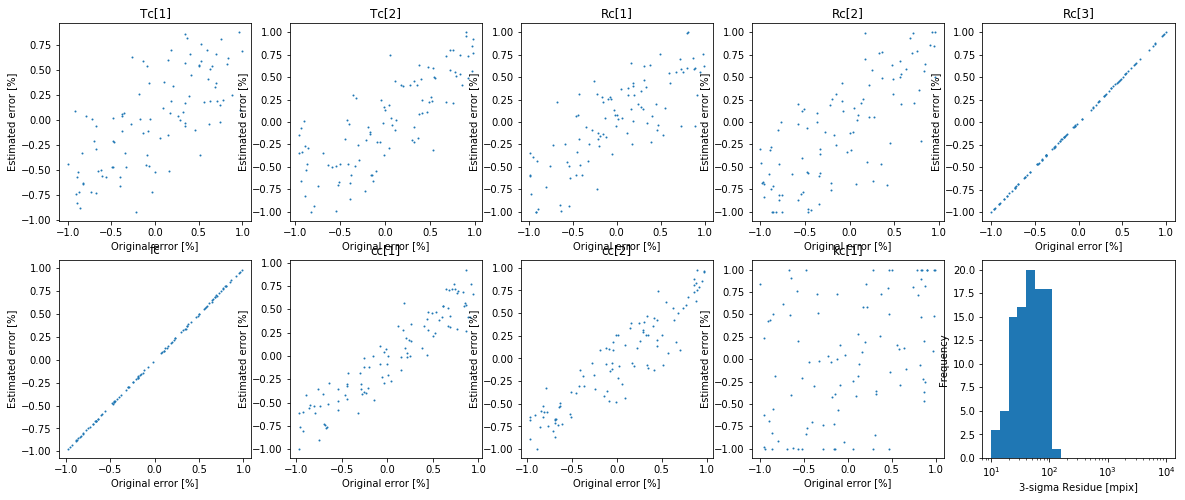

In [64]:
TestFitting("3step_iterate.pdf")

### 2. **Rc[3], fc** first

In [65]:
from scipy import optimize as opt

def RecalibrateParameter(arrPlate,arrPix,paramsFid):
    # 1. Initialize three types of parameters by using fiducial choice:
    # - criticalAParam = [Rc[2],fc]
    # - criticalBParam = [Tc[0],Tc[1],cc[0],cc[1]]
    # - probableParam = [Rc[0],Rc[1],kc[0]]
    # - redundantParam = [kc[1],kc[2],kc[3],kc[4]]
    criticalA = np.array([paramsFid.Rc[2],paramsFid.fc],dtype=np.float64)
    criticalB = np.concatenate([paramsFid.Tc[:2],paramsFid.cc])
    probable = np.array([paramsFid.Rc[0],paramsFid.Rc[1],paramsFid.kc[0]],dtype=np.float64)
    redundant = np.copy(paramsFid.kc[1:])
        
    criticalALP,criticalAHP = criticalA*0.99,criticalA*1.01
    criticalBLP,criticalBHP = criticalB*0.99,criticalB*1.01
    probableLP,probableHP = probable*0.99,probable*1.01
    
    criticalALB,criticalAUB = np.minimum(criticalALP,criticalAHP),np.maximum(criticalALP,criticalAHP)
    criticalBLB = np.minimum(criticalBLP,criticalBHP) + np.array([-np.abs(paramsFid.Tc[1]*0.01),0.,0.,0.],dtype=np.float64)
    criticalBUB = np.maximum(criticalBLP,criticalBHP) + np.array([np.abs(paramsFid.Tc[1]*0.01),0.,0.,0.],dtype=np.float64)
    probableLB,probableUB = np.minimum(probableLP,probableHP),np.maximum(probableLP,probableHP)
    redundantLB,redundantUB = -1E-6 * np.ones(4), 1E-6 * np.ones(4)
    
    # 2. Calibrate criticalAParam --> criticalBParam --> probableParam --> redundantParam
    # Here, calibrate multiple times
    for iteration in range(100):
        criticalAOld,criticalBOld,probableOld,redundantOld = np.copy(criticalA),np.copy(criticalB),np.copy(probable),np.copy(redundant)
        criticalA = opt.least_squares(ResidueChangeCriticalA,criticalAOld,
                                     args=(arrPlate,arrPix,criticalBOld,probableOld,redundantOld),
                                     bounds=(criticalALB,criticalAUB),
                                     ftol=1E-16,xtol=1E-16).x
        criticalB = opt.least_squares(ResidueChangeCriticalB,criticalBOld,
                                     args=(arrPlate,arrPix,criticalA,probableOld,redundantOld),
                                     bounds=(criticalBLB,criticalBUB),
                                     ftol=1E-16,xtol=1E-16).x
        probable = opt.least_squares(ResidueChangeProbable,probableOld,
                                     args=(arrPlate,arrPix,criticalA,criticalB,redundantOld),
                                     bounds=(probableLB,probableUB),
                                     ftol=1E-16,xtol=1E-16).x
        redundant = opt.least_squares(ResidueChangeRedundant,redundantOld,
                                      args=(arrPlate,arrPix,criticalA,criticalB,probable),
                                      bounds=(redundantLB,redundantUB),
                                      ftol=1E-16,xtol=1E-16).x
        
        err = max(np.amax(np.abs((criticalA-criticalAOld)/criticalAOld)),
                  np.amax(np.abs((criticalB-criticalBOld)/criticalBOld)),
                  np.amax(np.abs((probable-probableOld)/probableOld)),
                  np.amax(np.abs((redundant-redundantOld)/redundantOld)))
        if err < 1E-6:
            break

    newParam = ConstructParameter(criticalA,criticalB,probable,redundant)
    return newParam


def ConstructParameter(criticalA,criticalB,probable,redundant):
    params = Parameter()
    TcSq = params.Tc[0]**2 + params.Tc[1]**2 + params.Tc[2]**2
    params.Tc = np.array([criticalB[0],criticalB[1],-np.sqrt(TcSq - criticalB[0]**2 - criticalB[1]**2)])
    params.Rc = np.array([probable[0],probable[1],criticalA[0]])
    params.fc = criticalA[1]
    params.kc = np.array([probable[2],redundant[0],redundant[1],redundant[2],redundant[3]])
    params.cc = np.array([criticalB[2],criticalB[3]])
    return params

def ResidueChangeCriticalA(criticalA,arrPlate,arrPix,criticalB,probable,redundant):
    params = ConstructParameter(criticalA,criticalB,probable,redundant)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

def ResidueChangeCriticalB(criticalB,arrPlate,arrPix,criticalA,probable,redundant):
    params = ConstructParameter(criticalA,criticalB,probable,redundant)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

def ResidueChangeProbable(probable,arrPlate,arrPix,criticalA,criticalB,redundant):
    params = ConstructParameter(criticalA,criticalB,probable,redundant)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

def ResidueChangeRedundant(redundant,arrPlate,arrPix,criticalA,criticalB,probable):
    params = ConstructParameter(criticalA,criticalB,probable,redundant)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide


 Done sample 100

<Figure size 432x288 with 0 Axes>

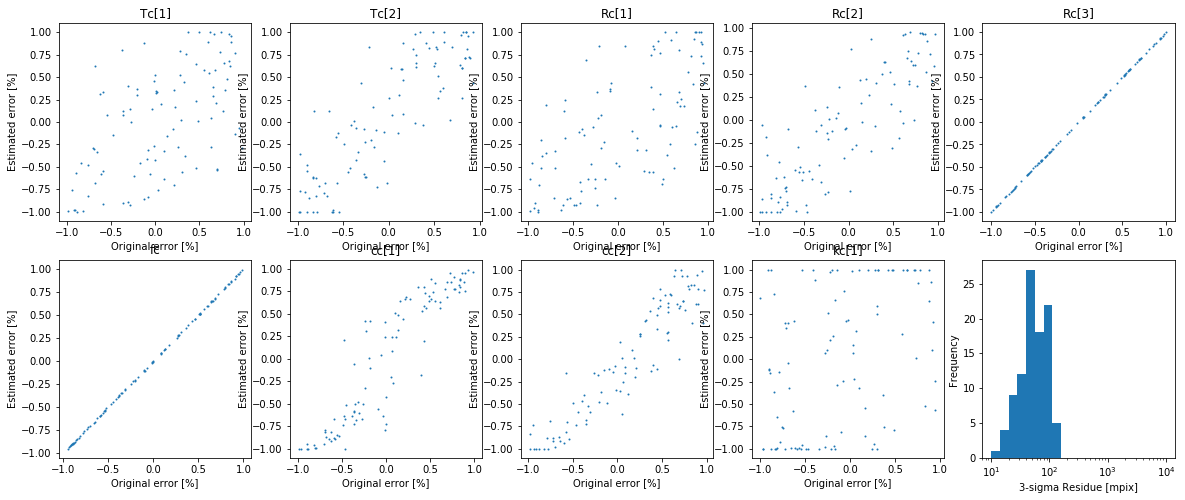

In [66]:
TestFitting("4step_iterate.pdf")

### 3. **Rc[3], fc, cc[]** first

In [67]:
from scipy import optimize as opt

def RecalibrateParameter(arrPlate,arrPix,paramsFid):
    # 1. Initialize three types of parameters by using fiducial choice:
    # - criticalAParam = [Rc[2],fc,cc[0],cc[1]]
    # - criticalBParam = [Tc[0],Tc[1]]
    # - probableParam = [Rc[0],Rc[1],kc[0]]
    # - redundantParam = [kc[1],kc[2],kc[3],kc[4]]
    criticalA = np.array([paramsFid.Rc[2],paramsFid.fc,paramsFid.cc[0],paramsFid.cc[1]],dtype=np.float64)
    criticalB = np.copy(paramsFid.Tc[:2])
    probable = np.array([paramsFid.Rc[0],paramsFid.Rc[1],paramsFid.kc[0]],dtype=np.float64)
    redundant = np.copy(paramsFid.kc[1:])
        
    criticalALP,criticalAHP = criticalA*0.99,criticalA*1.01
    criticalBLP,criticalBHP = criticalB*0.99,criticalB*1.01
    probableLP,probableHP = probable*0.99,probable*1.01
    
    criticalALB,criticalAUB = np.minimum(criticalALP,criticalAHP),np.maximum(criticalALP,criticalAHP)
    criticalBLB = np.minimum(criticalBLP,criticalBHP) + np.array([-np.abs(paramsFid.Tc[1]*0.01),0.],dtype=np.float64)
    criticalBUB = np.maximum(criticalBLP,criticalBHP) + np.array([np.abs(paramsFid.Tc[1]*0.01),0.],dtype=np.float64)
    probableLB,probableUB = np.minimum(probableLP,probableHP),np.maximum(probableLP,probableHP)
    redundantLB,redundantUB = -1E-6 * np.ones(4), 1E-6 * np.ones(4)
    
    # 2. Calibrate criticalAParam --> criticalBParam --> probableParam --> redundantParam
    # Here, calibrate multiple times
    for iteration in range(100):
        criticalAOld,criticalBOld,probableOld,redundantOld = np.copy(criticalA),np.copy(criticalB),np.copy(probable),np.copy(redundant)
        criticalA = opt.least_squares(ResidueChangeCriticalA,criticalAOld,
                                     args=(arrPlate,arrPix,criticalBOld,probableOld,redundantOld),
                                     bounds=(criticalALB,criticalAUB),
                                     ftol=1E-16,xtol=1E-16).x
        criticalB = opt.least_squares(ResidueChangeCriticalB,criticalBOld,
                                     args=(arrPlate,arrPix,criticalA,probableOld,redundantOld),
                                     bounds=(criticalBLB,criticalBUB),
                                     ftol=1E-16,xtol=1E-16).x
        probable = opt.least_squares(ResidueChangeProbable,probableOld,
                                     args=(arrPlate,arrPix,criticalA,criticalB,redundantOld),
                                     bounds=(probableLB,probableUB),
                                     ftol=1E-16,xtol=1E-16).x
        redundant = opt.least_squares(ResidueChangeRedundant,redundantOld,
                                      args=(arrPlate,arrPix,criticalA,criticalB,probable),
                                      bounds=(redundantLB,redundantUB),
                                      ftol=1E-16,xtol=1E-16).x
        
        err = max(np.amax(np.abs((criticalA-criticalAOld)/criticalAOld)),
                  np.amax(np.abs((criticalB-criticalBOld)/criticalBOld)),
                  np.amax(np.abs((probable-probableOld)/probableOld)),
                  np.amax(np.abs((redundant-redundantOld)/redundantOld)))
        if err < 1E-6:
            break

    newParam = ConstructParameter(criticalA,criticalB,probable,redundant)
    return newParam


def ConstructParameter(criticalA,criticalB,probable,redundant):
    params = Parameter()
    TcSq = params.Tc[0]**2 + params.Tc[1]**2 + params.Tc[2]**2
    params.Tc = np.array([criticalB[0],criticalB[1],-np.sqrt(TcSq - criticalB[0]**2 - criticalB[1]**2)])
    params.Rc = np.array([probable[0],probable[1],criticalA[0]])
    params.fc = criticalA[1]
    params.kc = np.array([probable[2],redundant[0],redundant[1],redundant[2],redundant[3]])
    params.cc = np.array([criticalA[2],criticalA[3]])
    return params

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide


 Done sample 100

<Figure size 432x288 with 0 Axes>

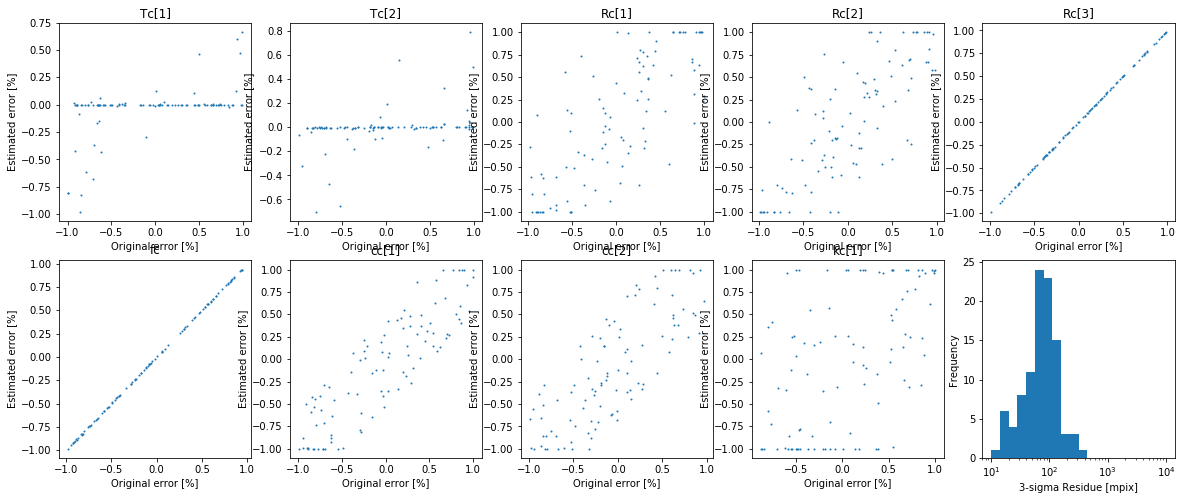

In [68]:
TestFitting("4step2_iterate.pdf")

Summary:
- 3-round iteration or 4-round iteration with **Rc[3], fc**-first gives the best result, in case with plate fiducial only.
- The median $3\sigma$ residue for the best cases is around 50 mpix (~25 microns). The median value itself seems to be within the requirement, but still there are many chances (~30%?) that the $3\sigma$ residue is beyond the requirement. Also, it is always good to have better things.

Anyway, the above result would be close to something that we can expect only from plate fiducials --- probably because it is nearly impossible to constrain **kc[]** with plate fiducials.
In the next section, let's add the guide bundle again.